In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor


In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from yellowbrick.regressor import PredictionError
import os
import pandas as pd
import matplotlib.pyplot as plt


class DistrictAnalysis:
    def __init__(self, csv_file,year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True)

    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        #self.df_main['Case_Count'] = self.df_main['Case_Count'] / (self.df_main['Population'] / 1000000)
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([ self.year]))]
        #train_data = train_data[train_data['Record_Week'] < 46]

        test_data = df[df['Year'] == self.year]
        #test_data = test_data[test_data['Record_Week'] < 46]

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        return x_train_scaled, x_test_scaled, y_train, y_test

    def boosting_regression(self, x_train, x_test, y_train, y_test):
        gbr_regressor = GradientBoostingRegressor(random_state=42)
        param_grid = {
          'n_estimators': range(10, 101),  # Number of boosting stages (trees)
          'learning_rate': [0.01, 0.1, 0.5],  # Controls step size in each update
          'max_depth': range(3, 8),  # Maximum depth of individual trees
      }
    
        grid_search = RandomizedSearchCV(estimator=gbr_regressor, param_distributions=param_grid,n_iter=300, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_gbr_regressor = grid_search.best_estimator_
    
        y_pred = best_gbr_regressor.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
    
        return y_pred, rmse

    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)',
                             'R-squared (R2)', 'Explained Variance Score',
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics
    
    
        
    def plot_prediction(self, district_name,rmse, y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        # Save the plot
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'Boosting')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

        #plt.show()

    def plot_yellowbrick_prediction_error(self, district_name, x_train, y_train, x_test, y_test):
        visualizer = PredictionError(RandomForestRegressor(random_state=42))
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        
        plt.title(f'Prediction Error for {district_name}')
        visualizer.poof()
        
    
        
    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []
        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            #self.plot_yellowbrick_prediction_error(district_name, x_train, y_train, x_test, y_test)
            y_pred_svr, rmse_svr = self.boosting_regression(x_train, x_test, y_train, y_test)
            performance = "Good" if rmse_svr < 2 else "Bad"
    
            # Create a dictionary for each district's data
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }
    
            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            self.plot_prediction(district_name,rmse_svr, y_pred_svr, y_test)
            print("=" * 100)
        return final_df





    





Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


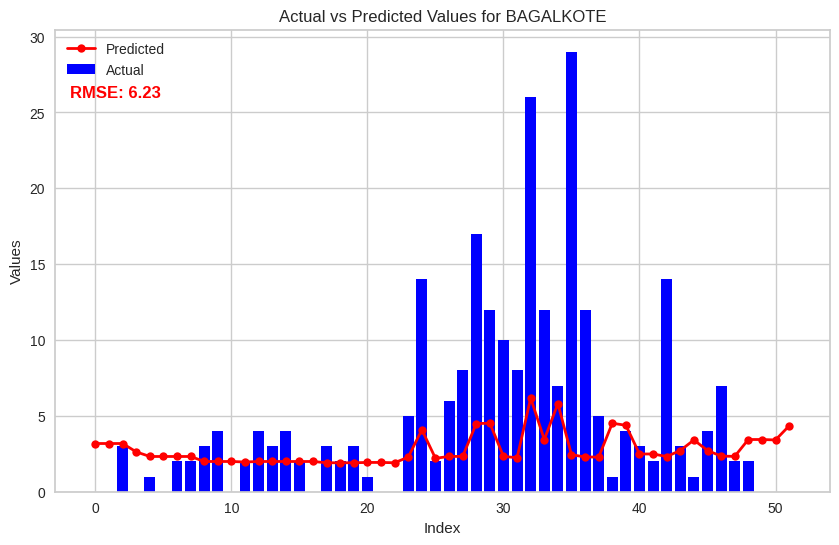

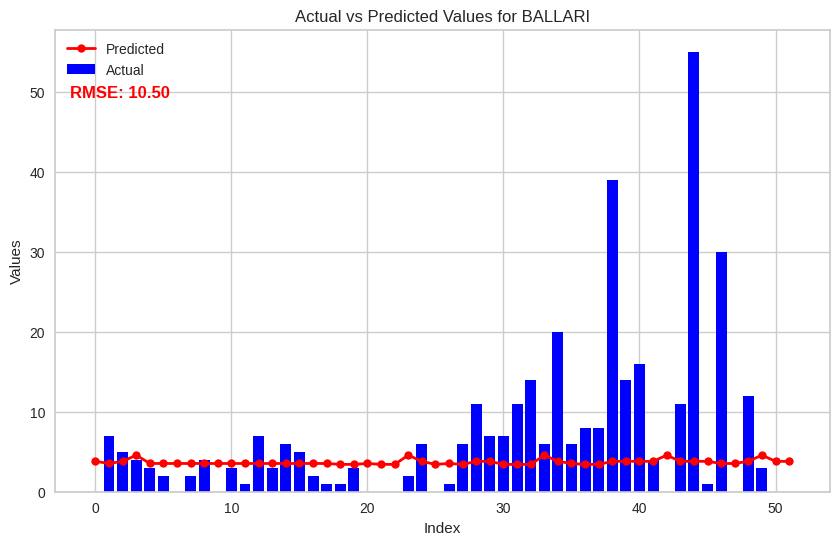

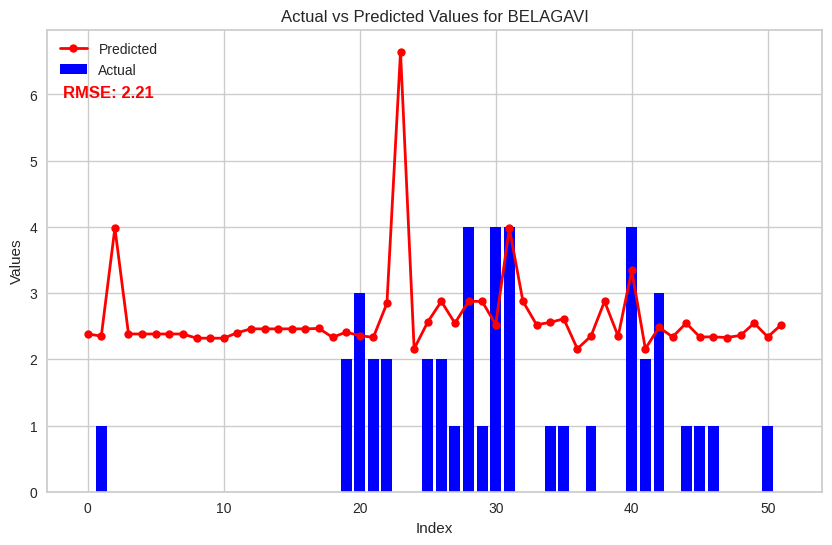

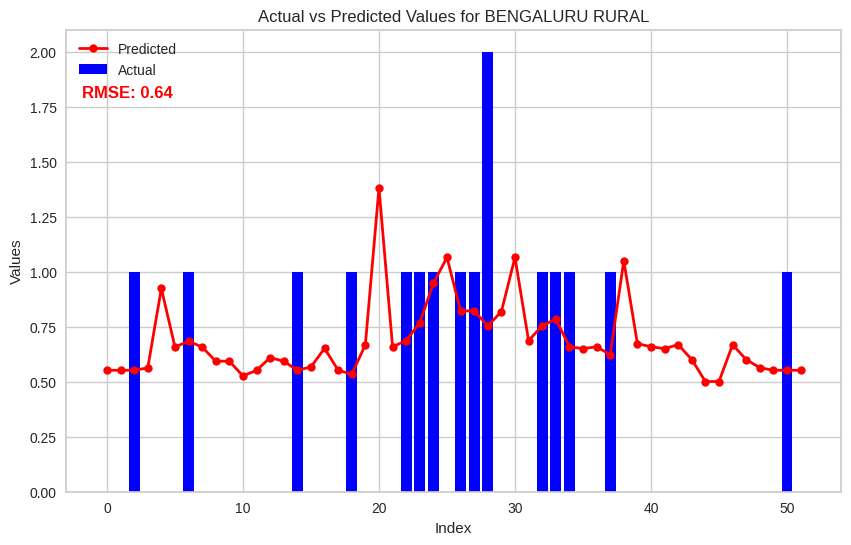

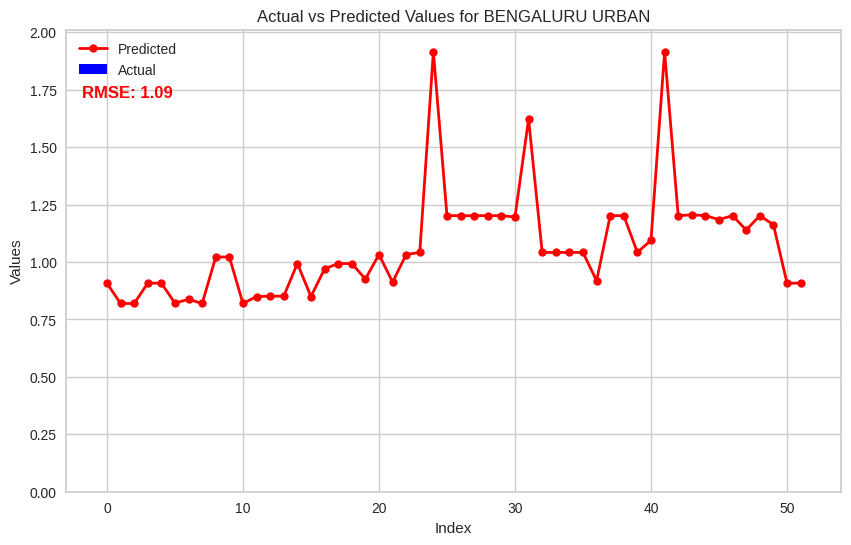

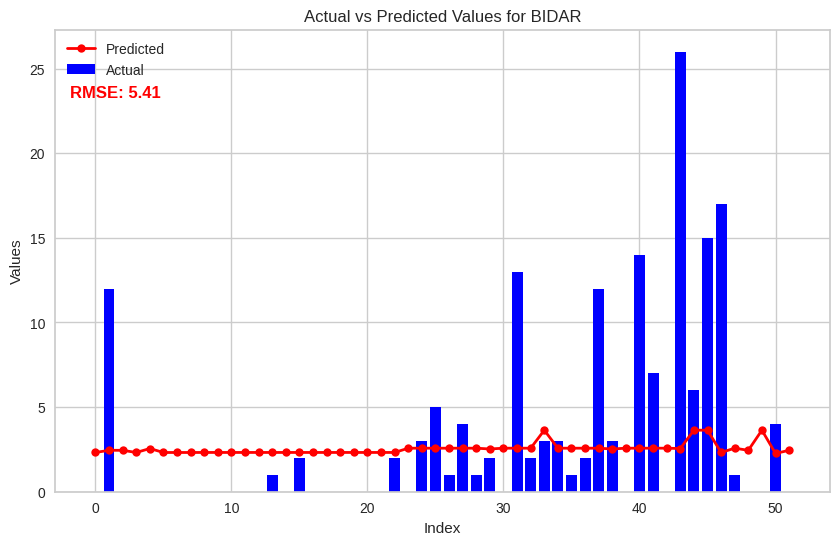

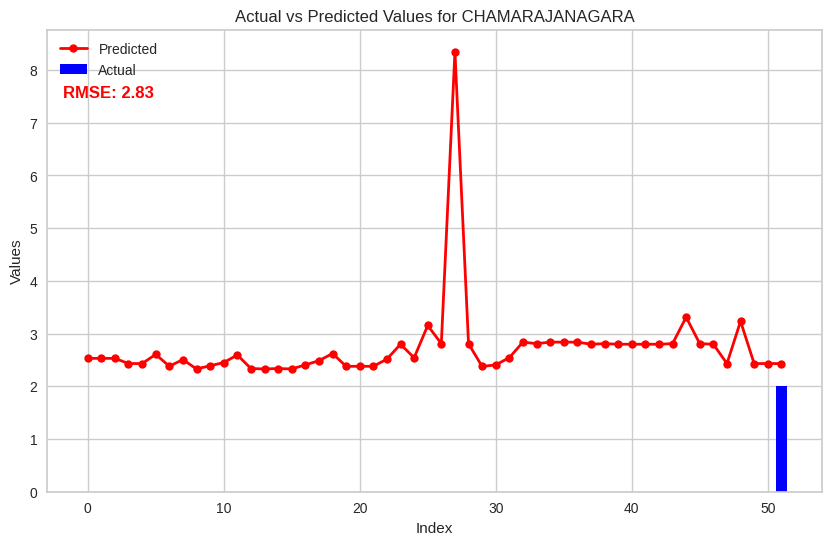

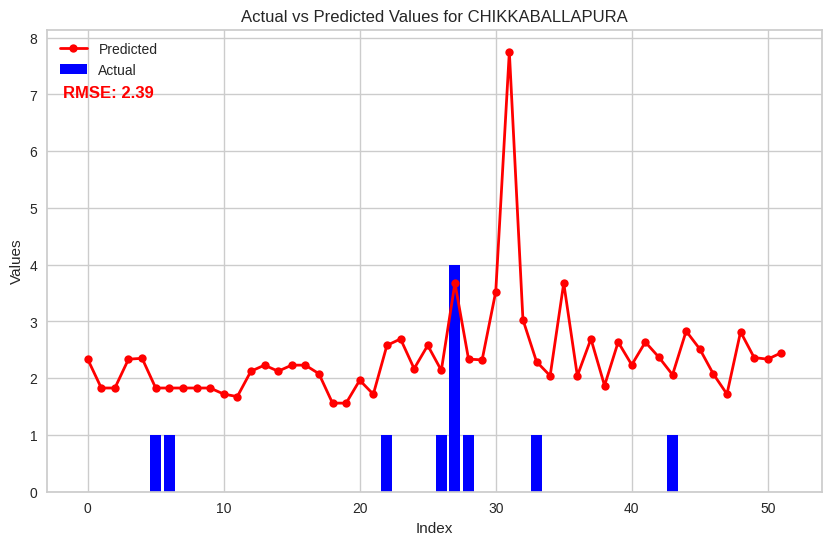

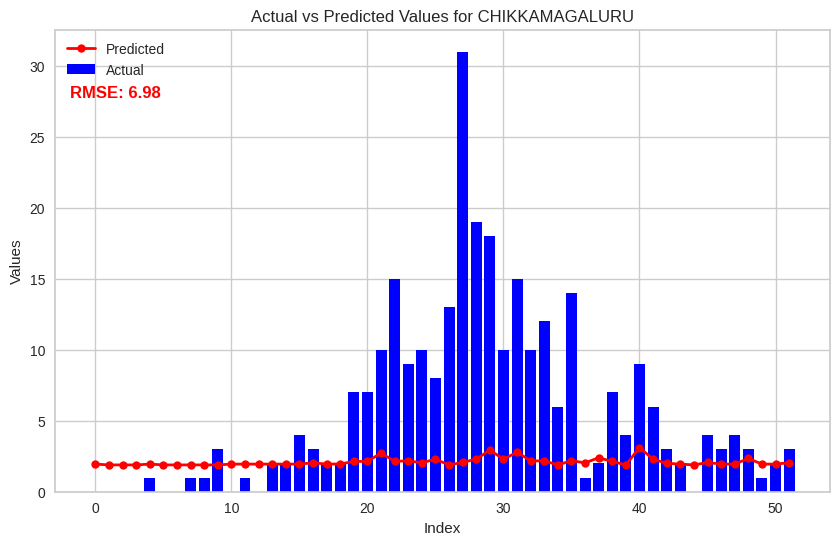

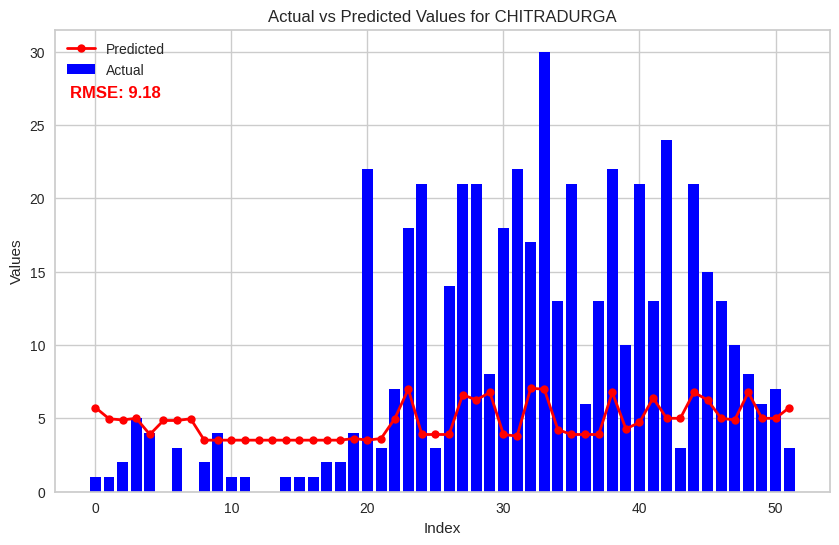

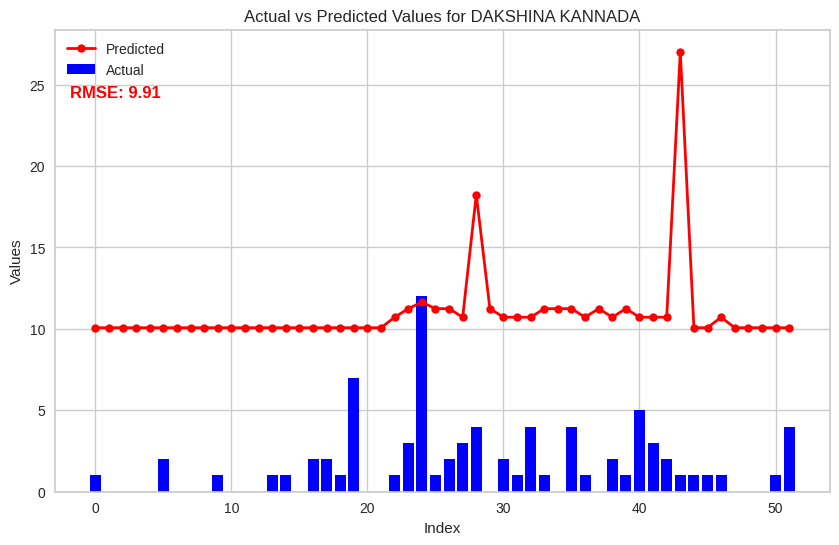

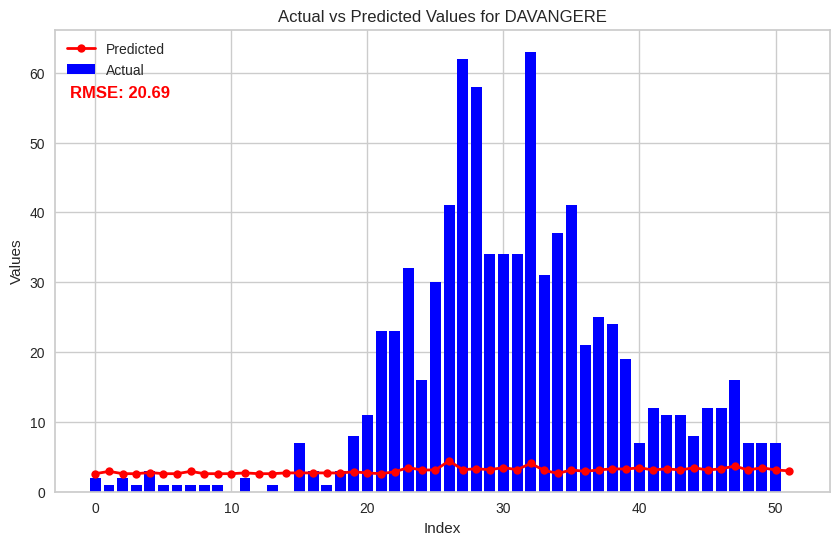

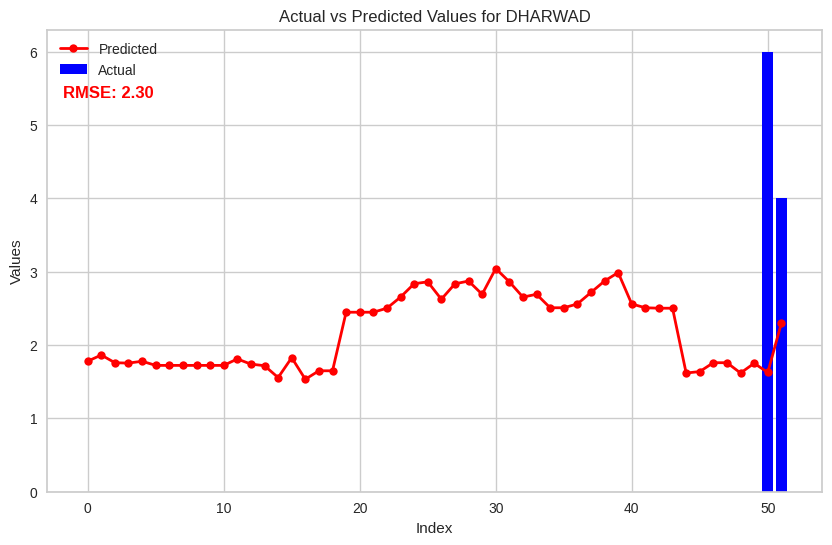

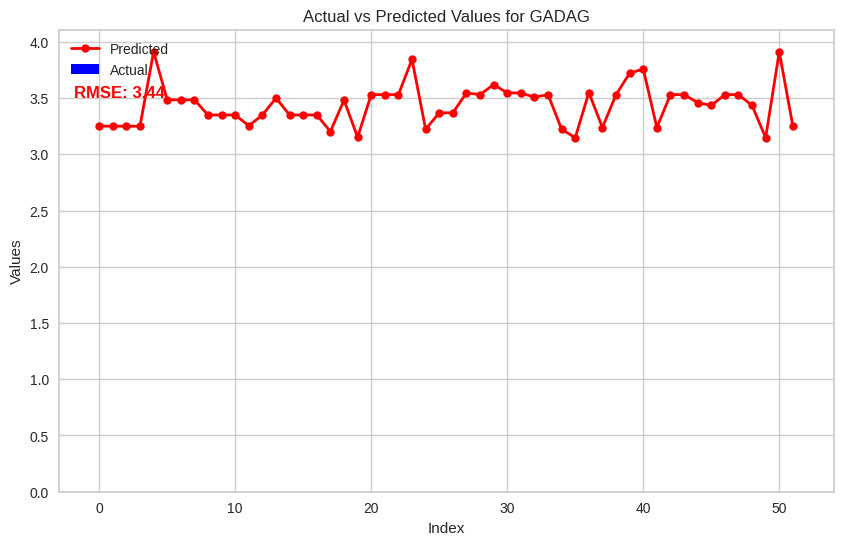

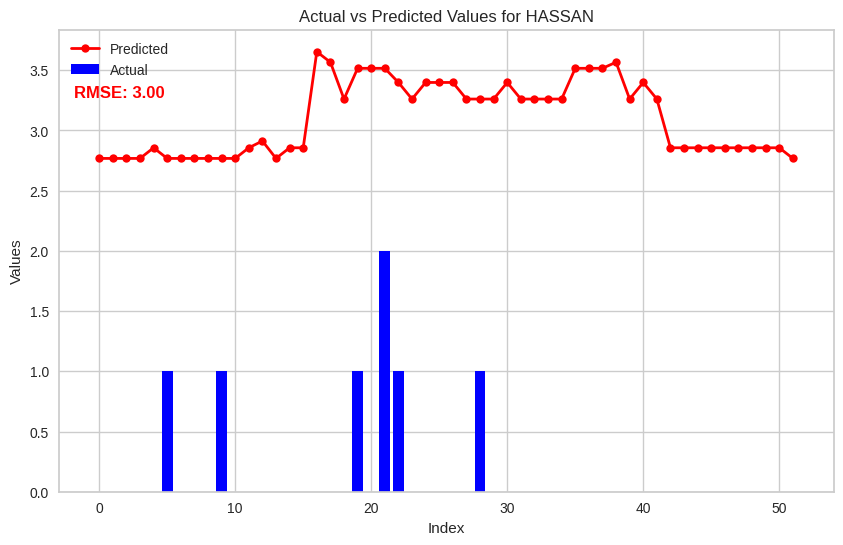

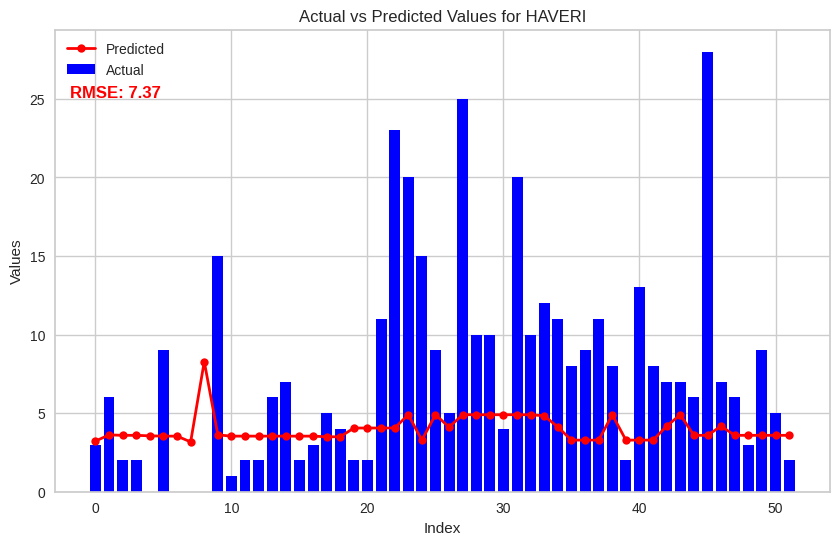

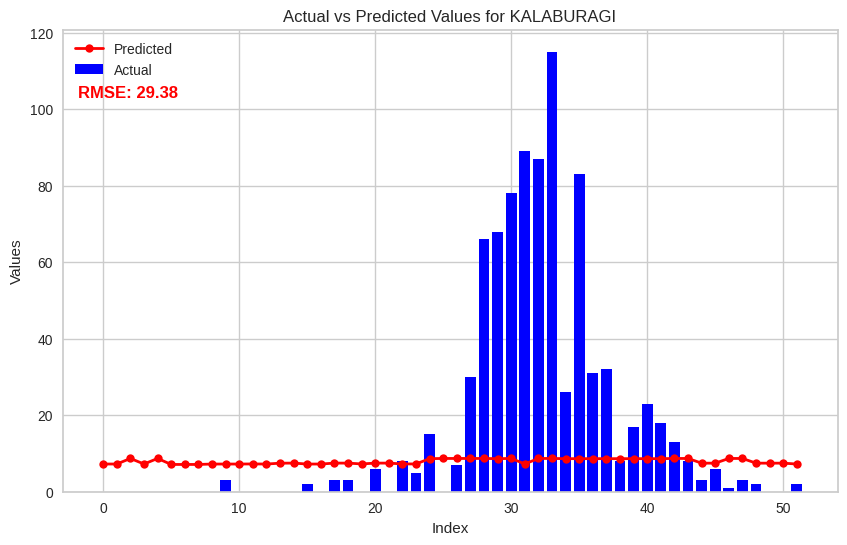

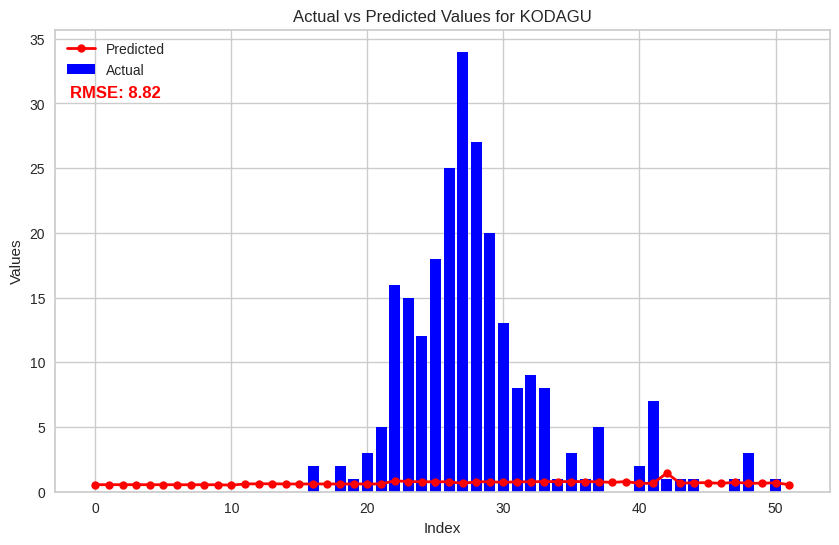

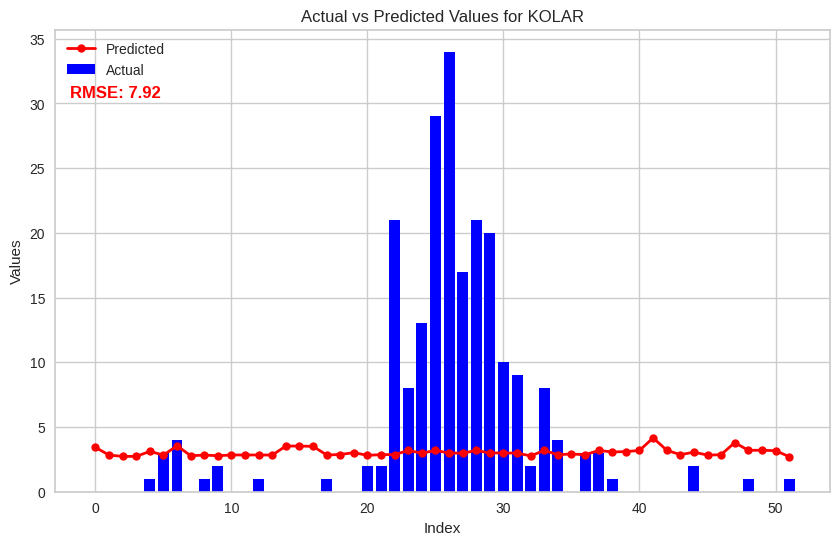

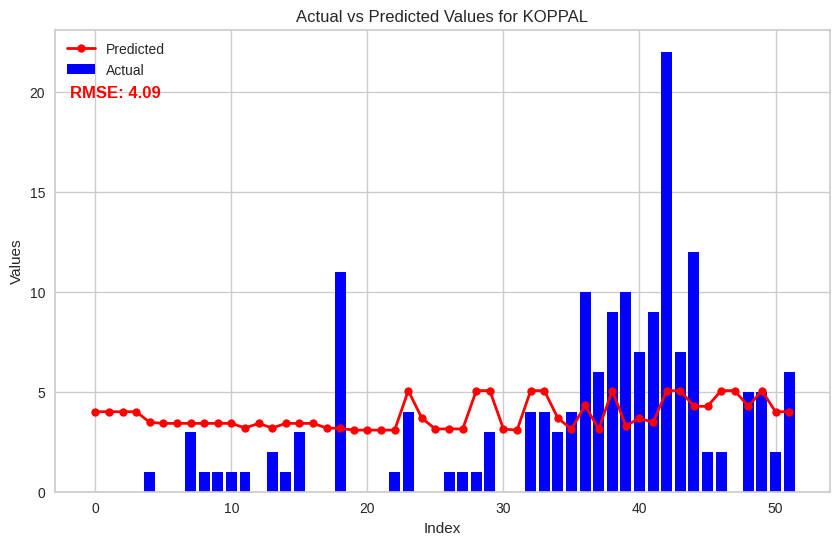

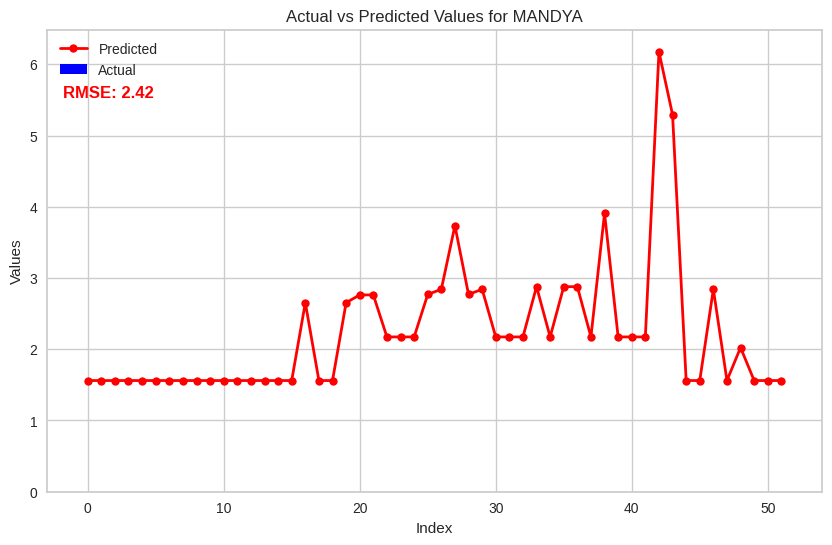

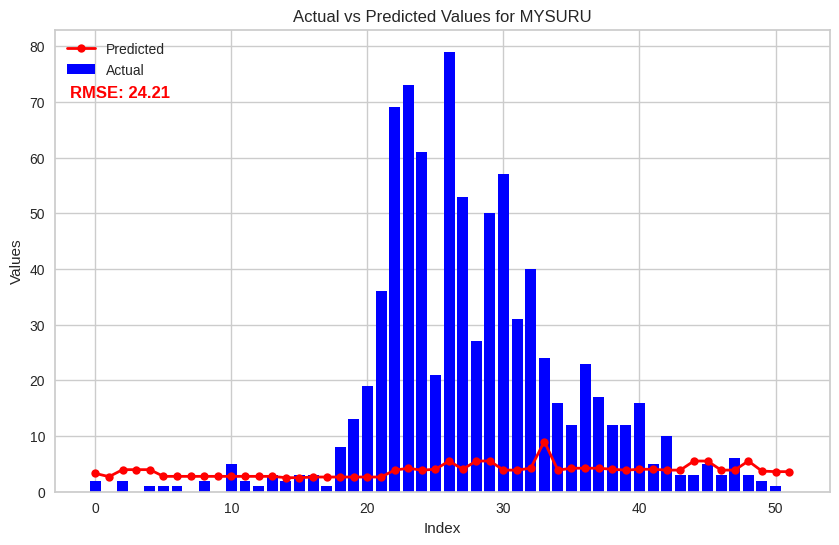

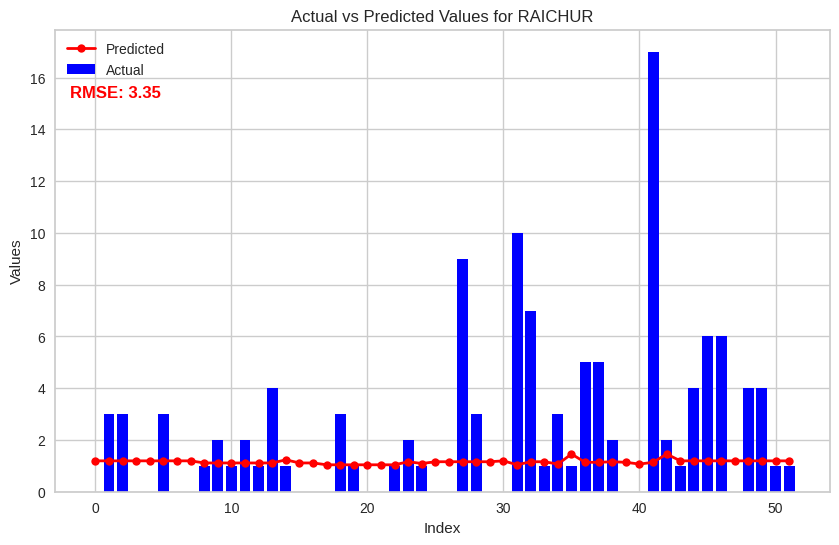

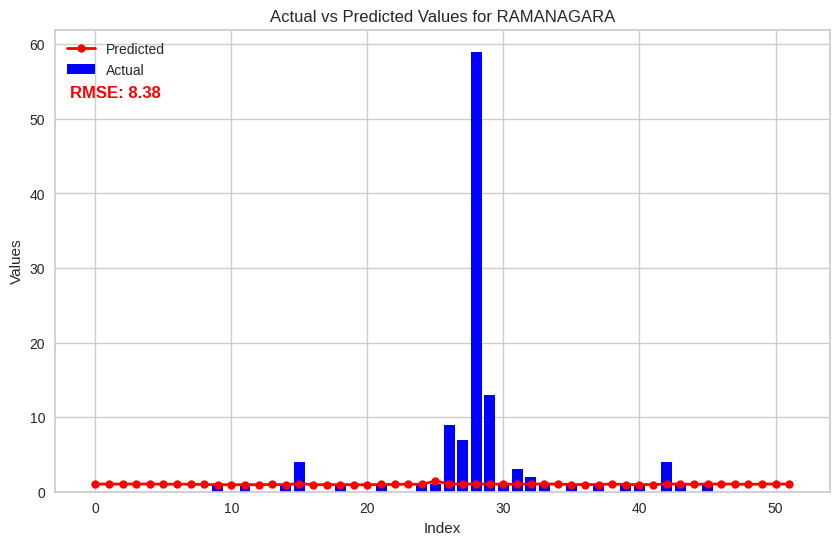

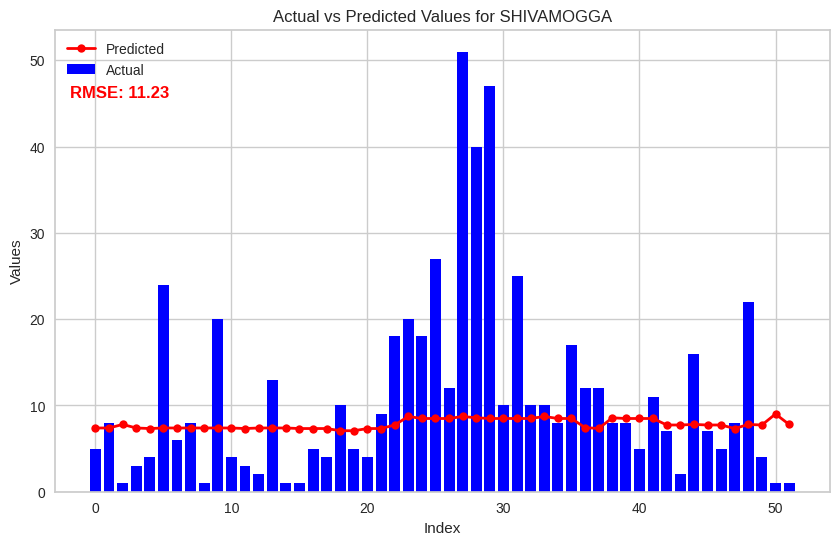

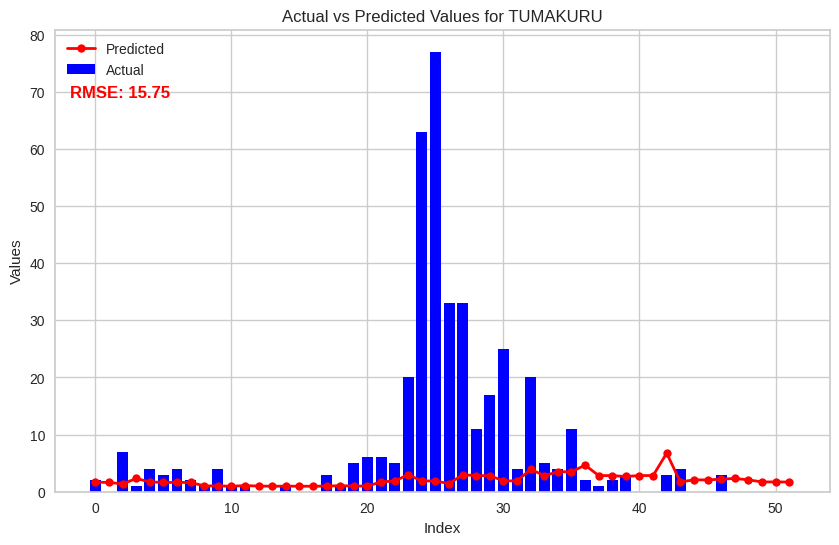

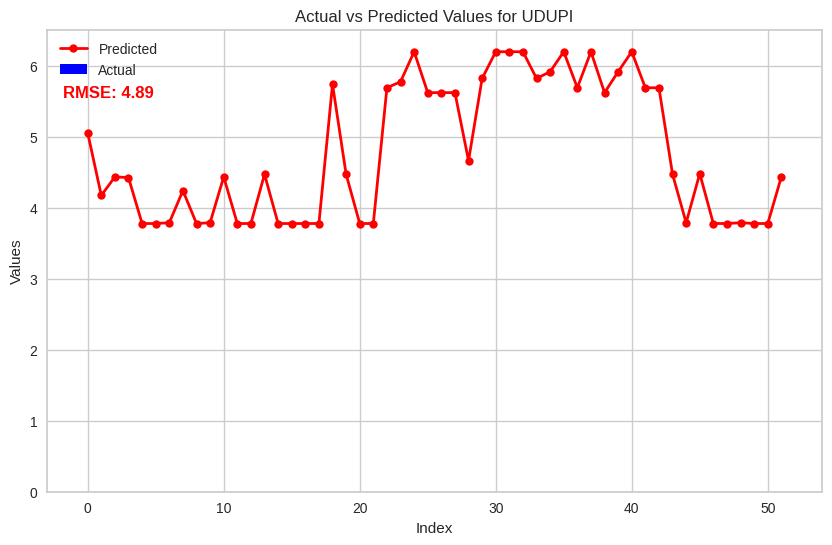

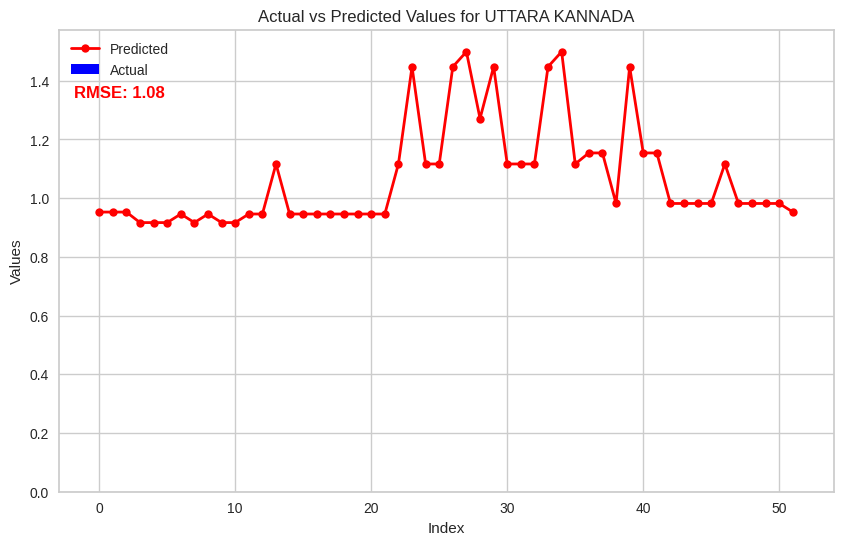

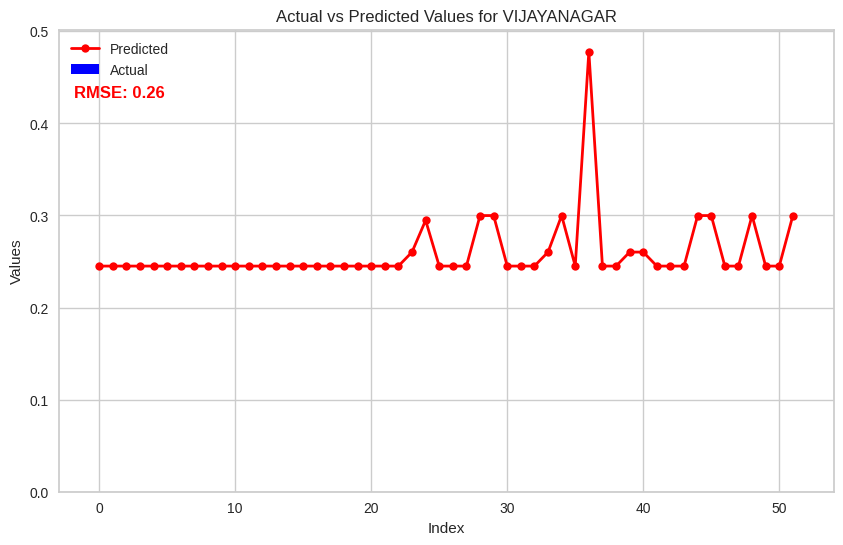

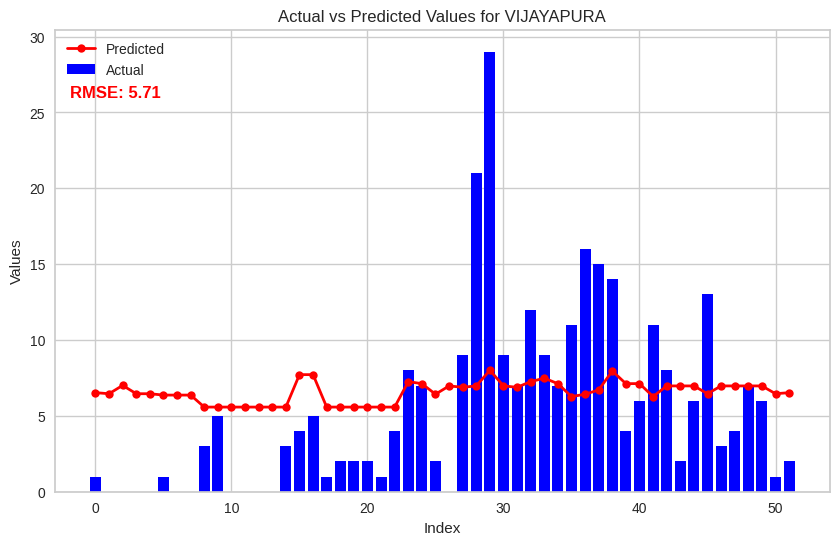

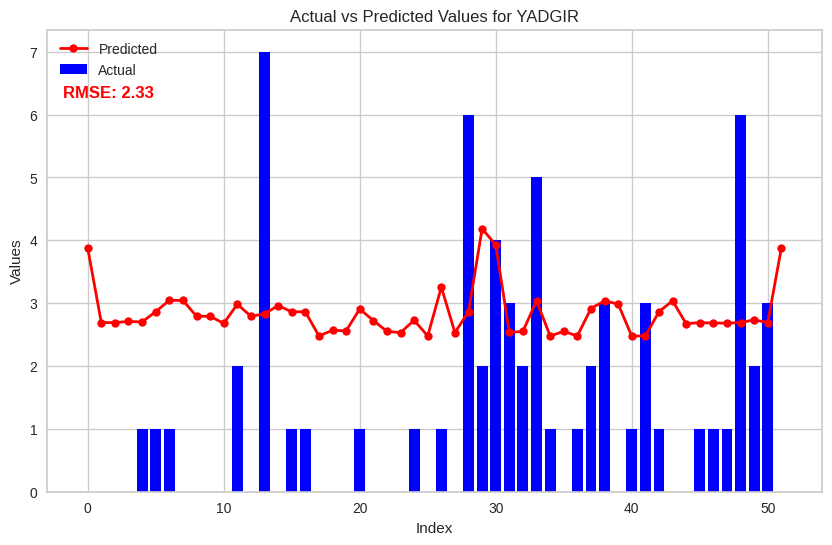

In [26]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


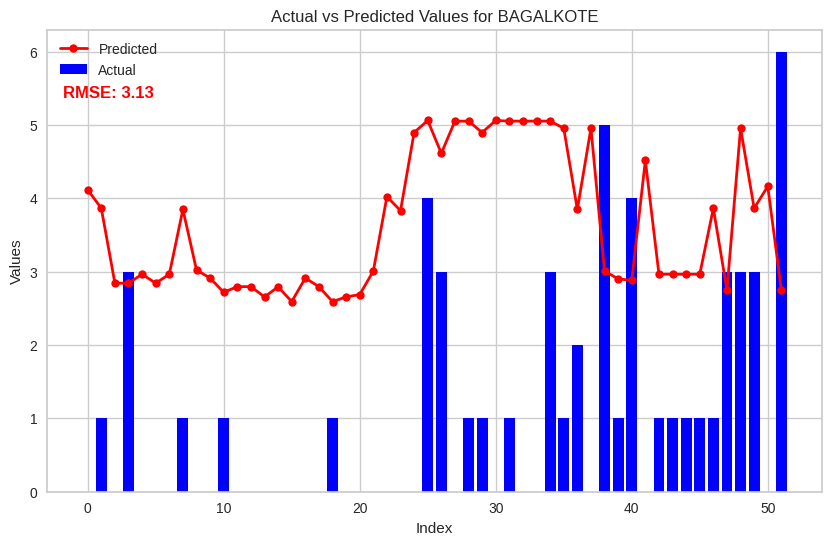

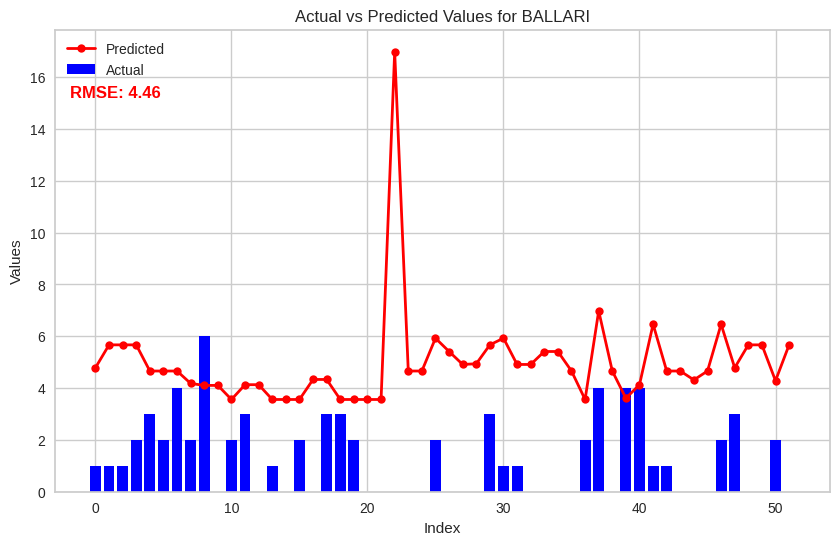

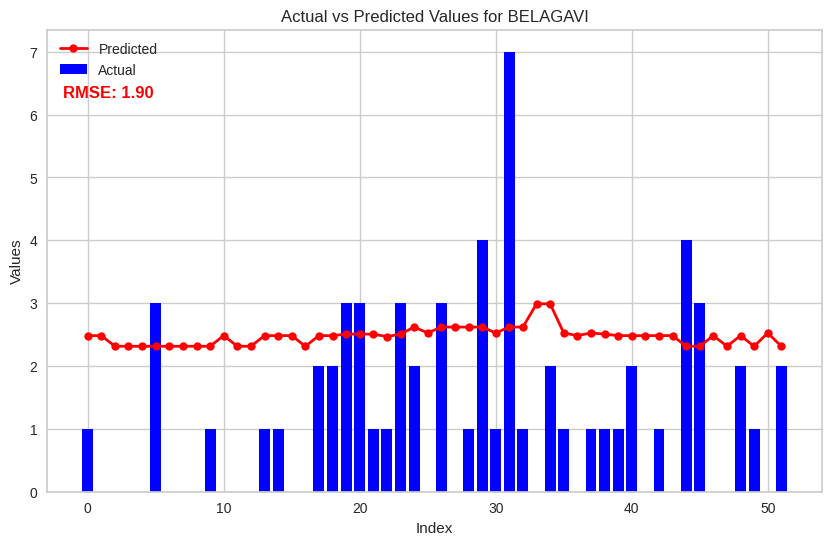

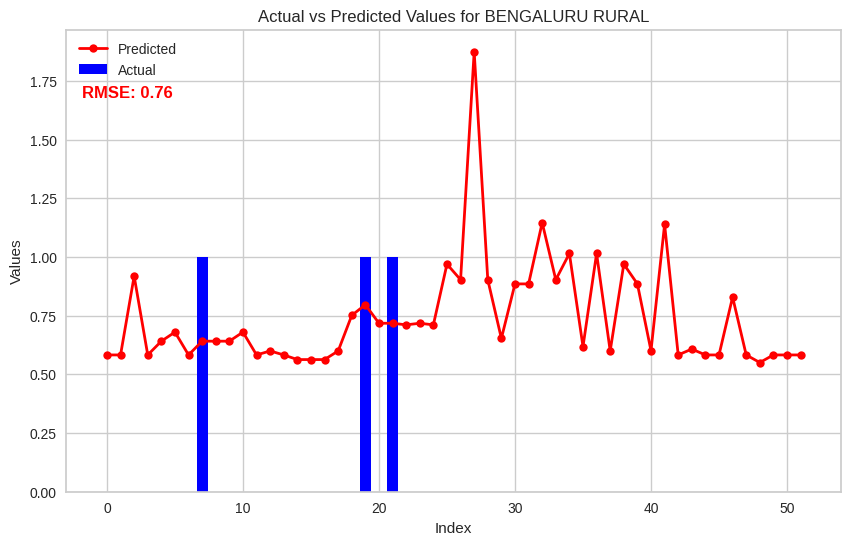

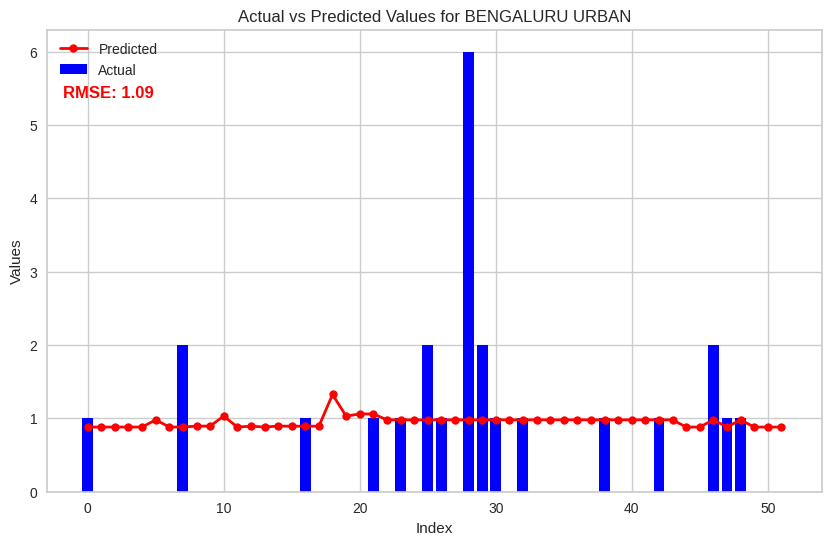

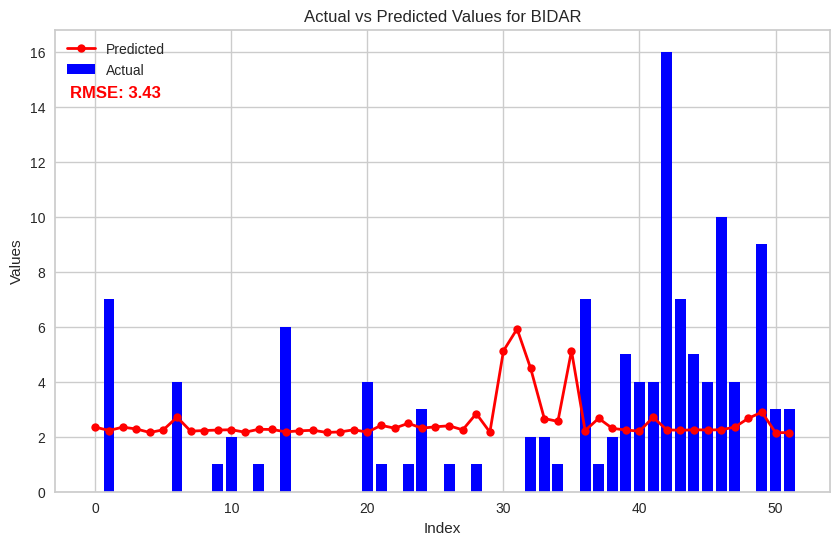

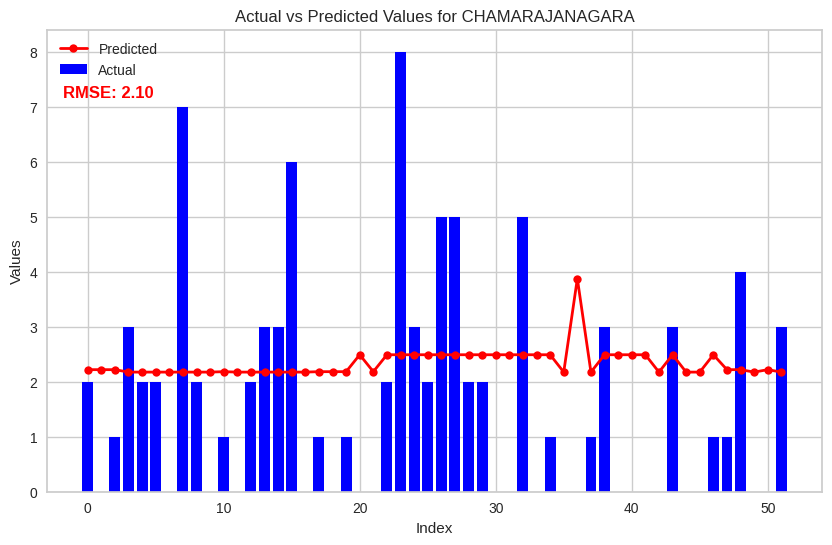

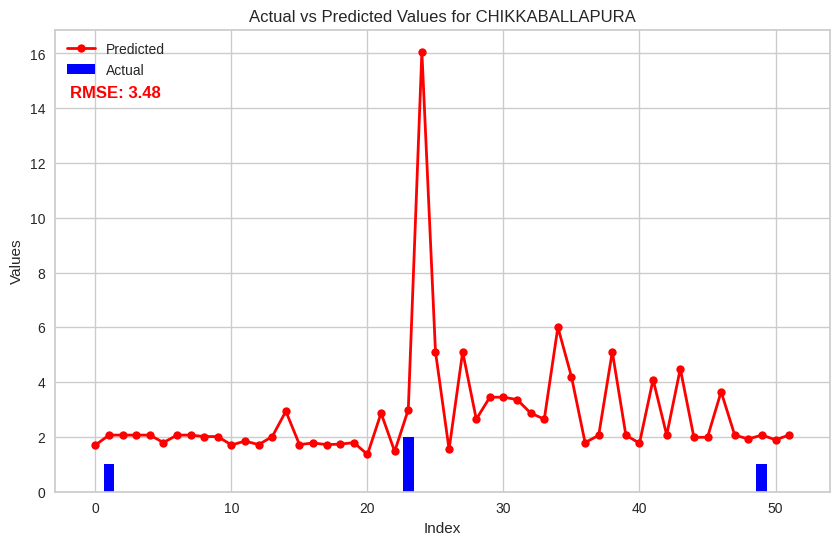

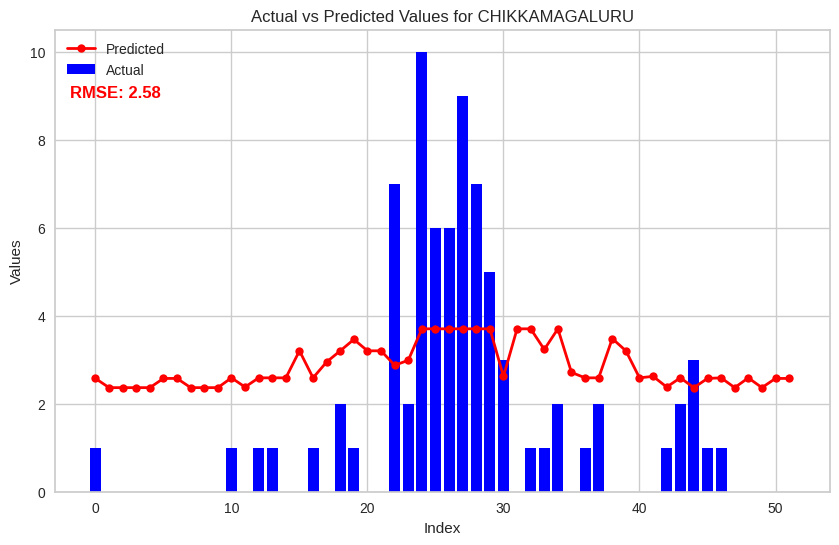

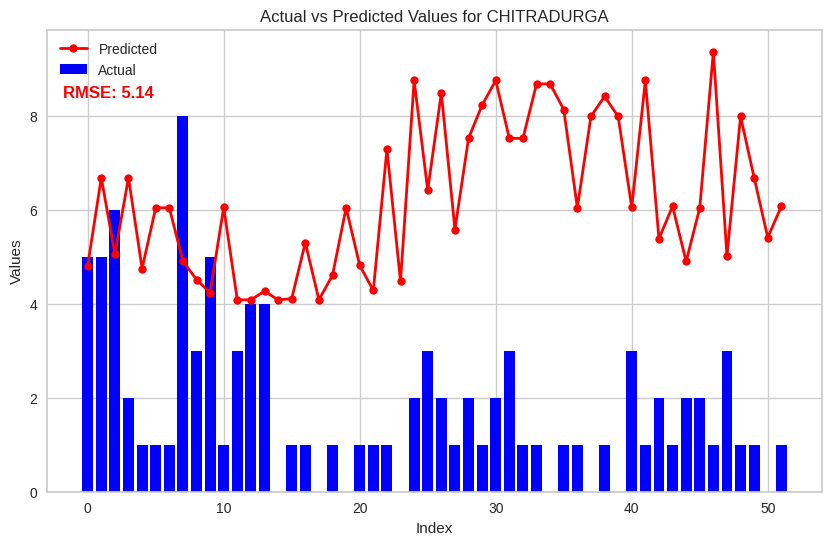

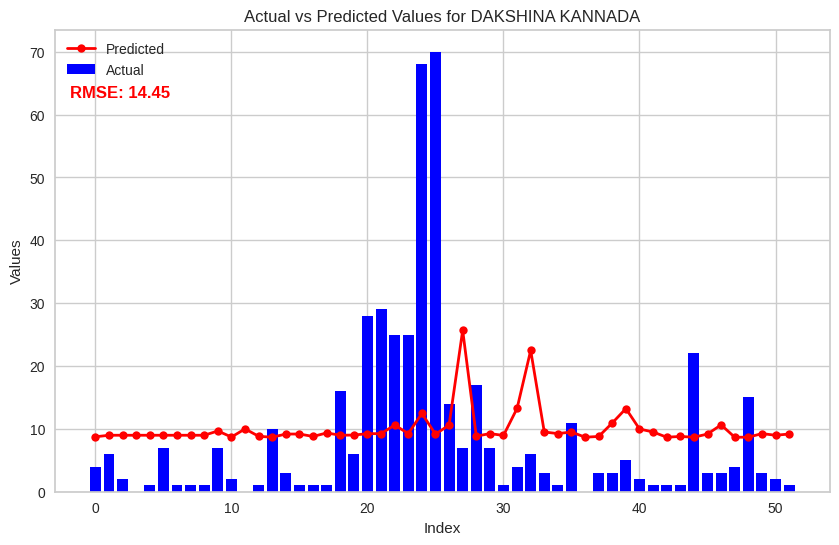

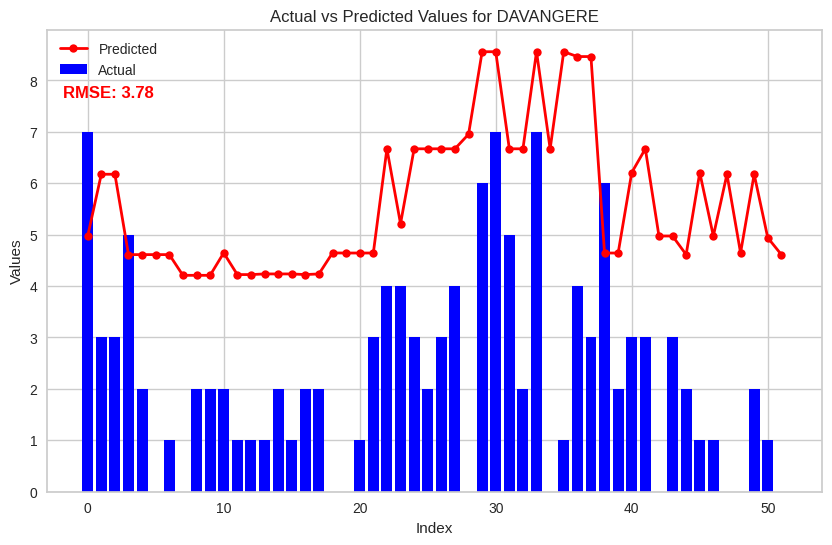

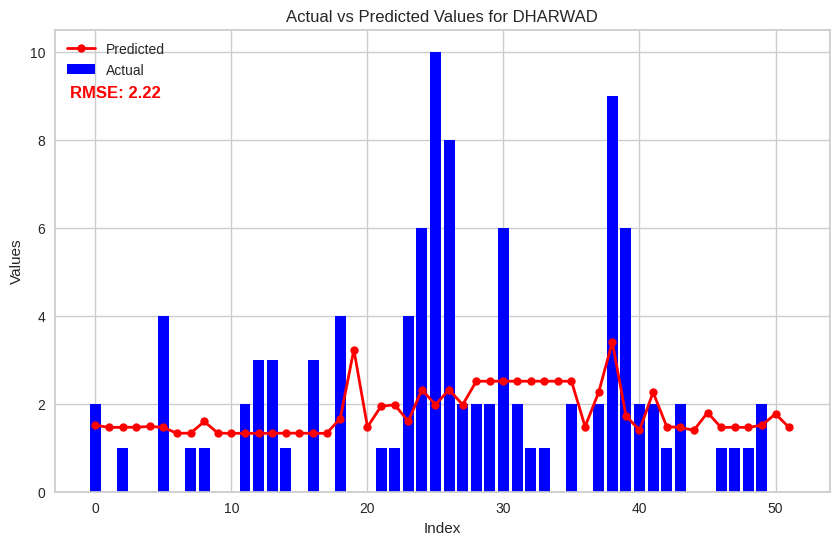

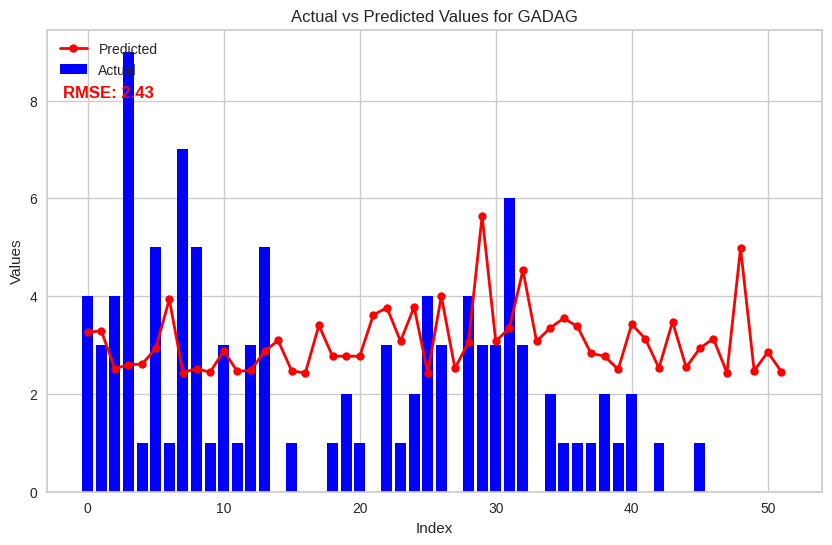

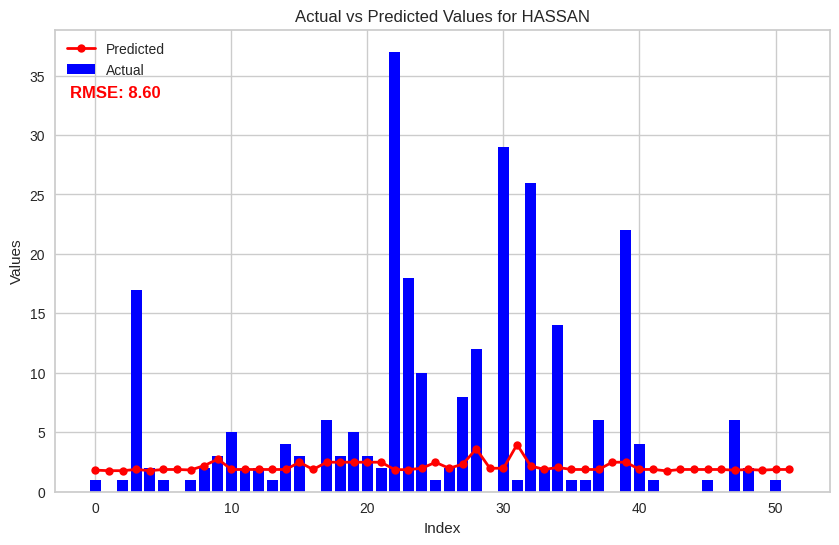

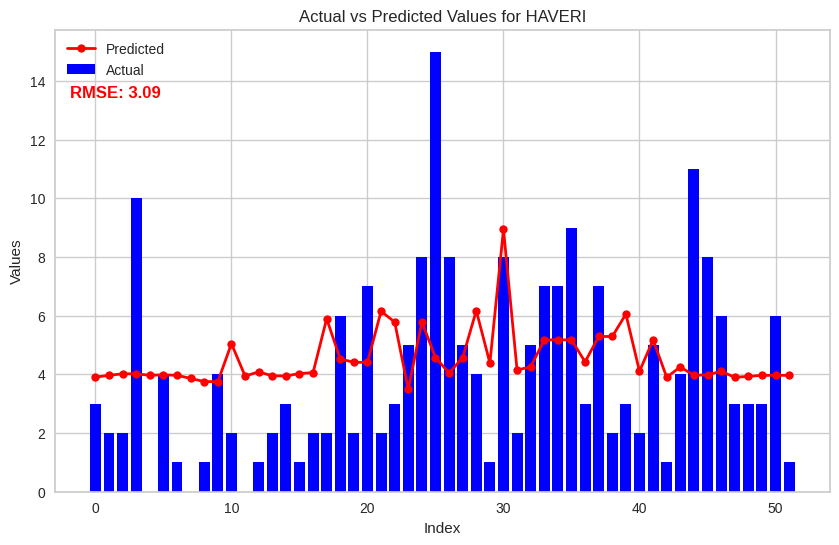

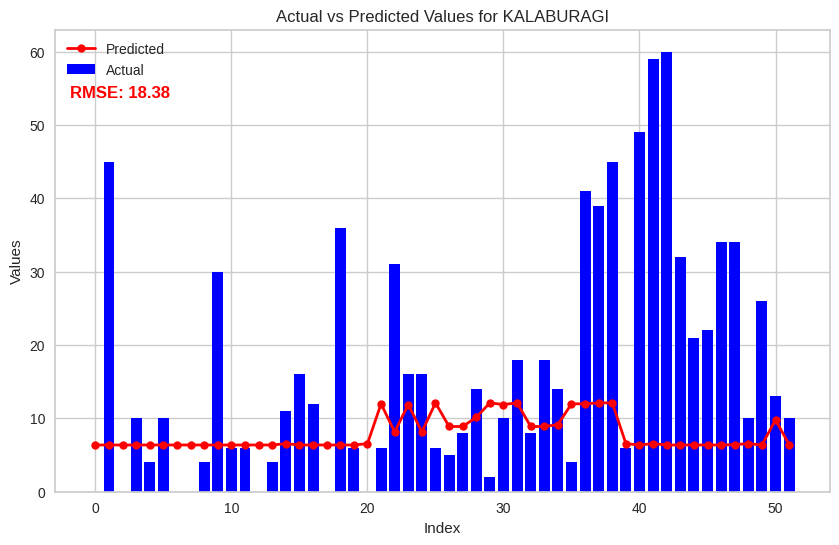

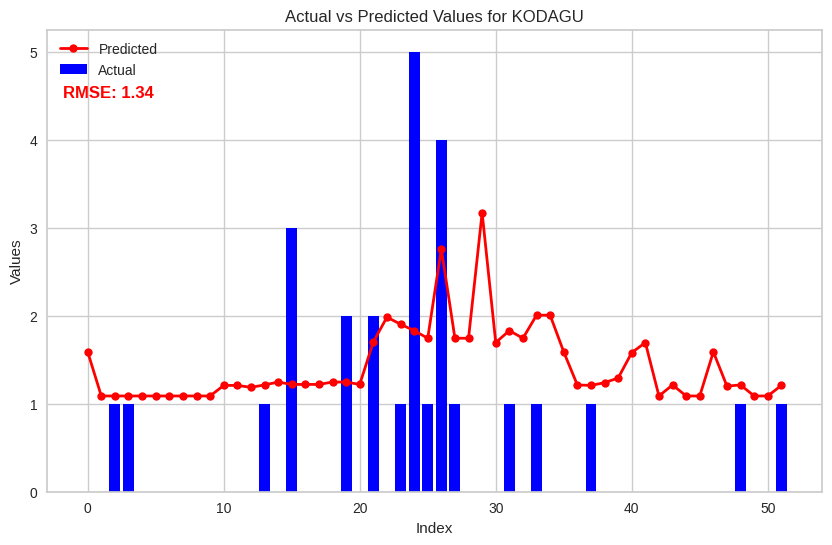

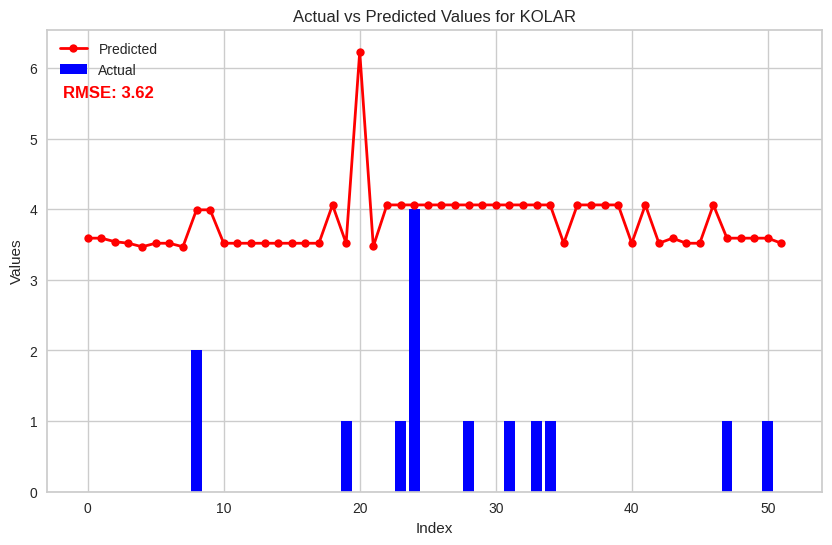

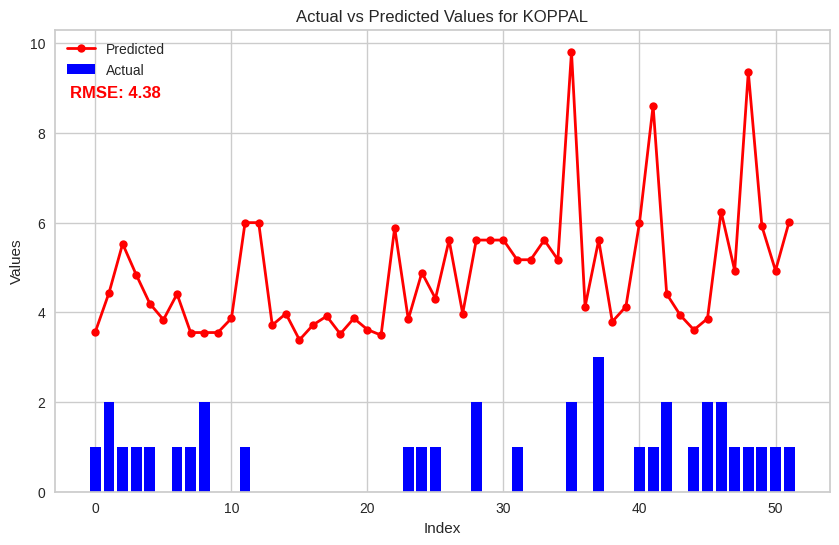

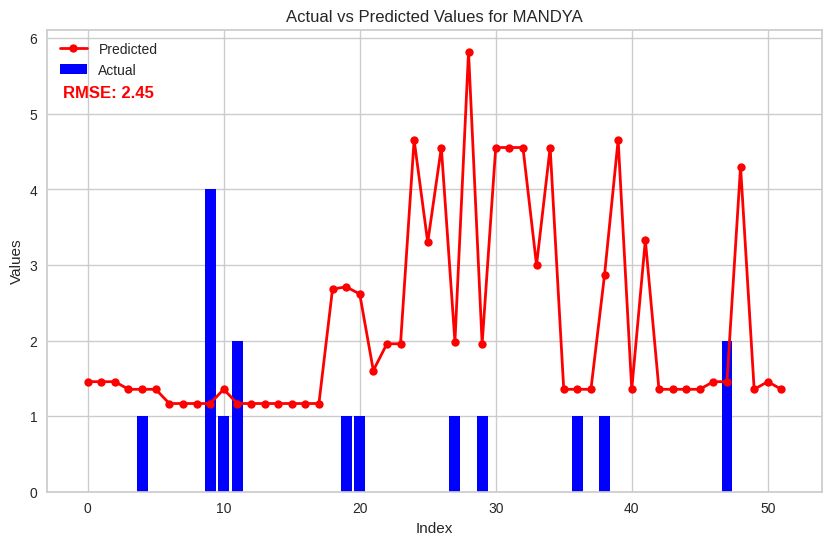

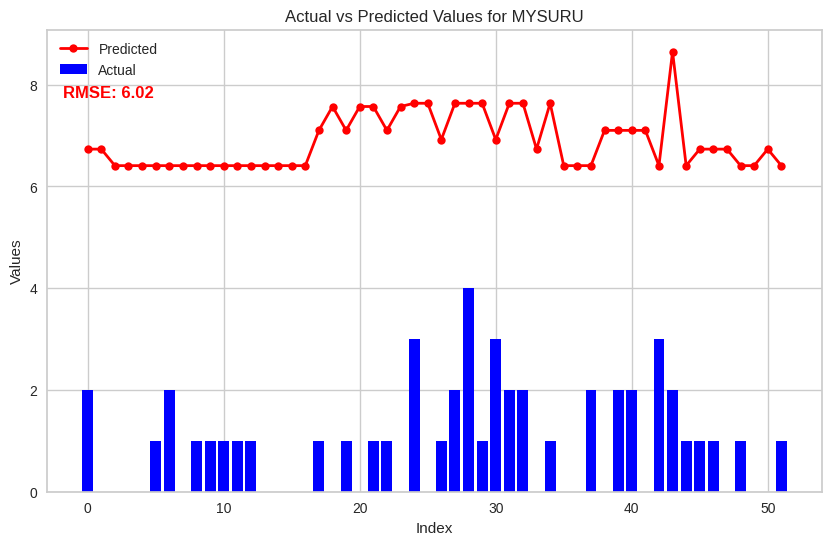

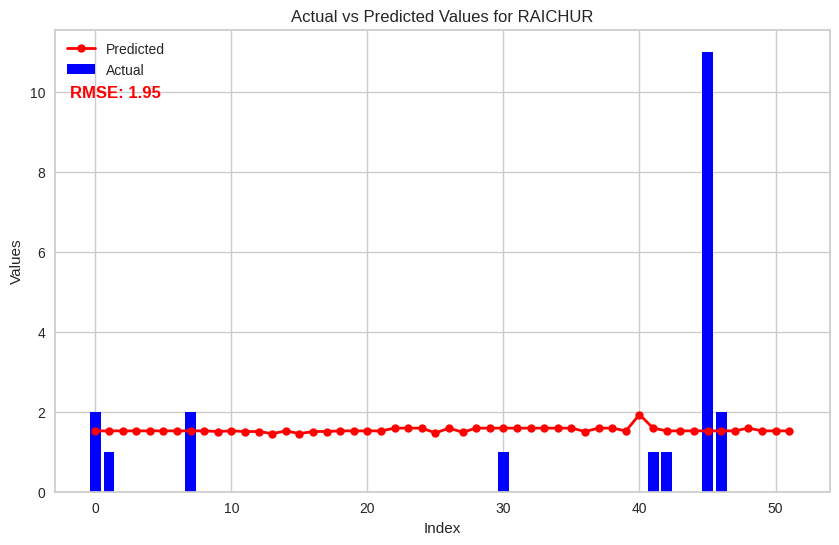

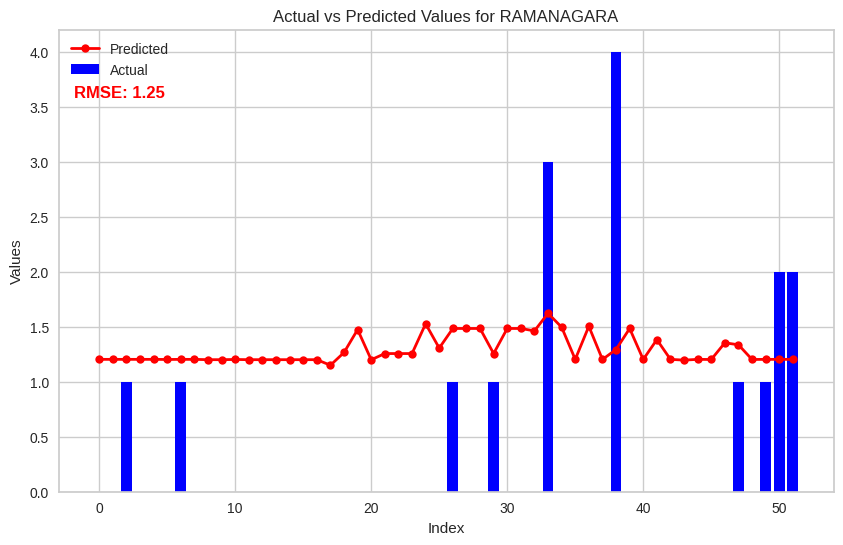

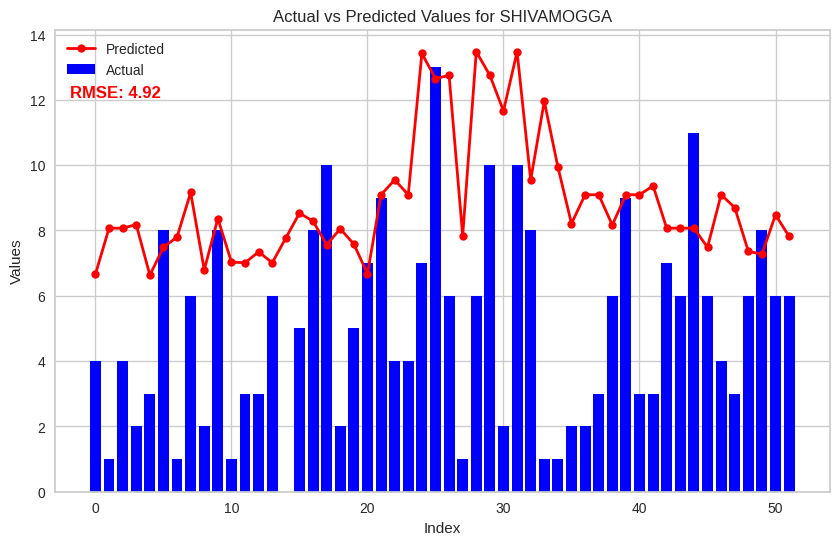

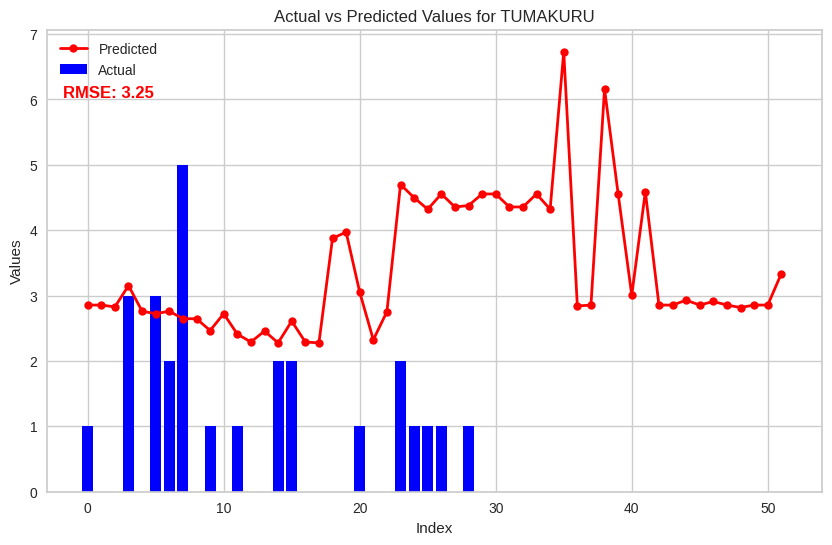

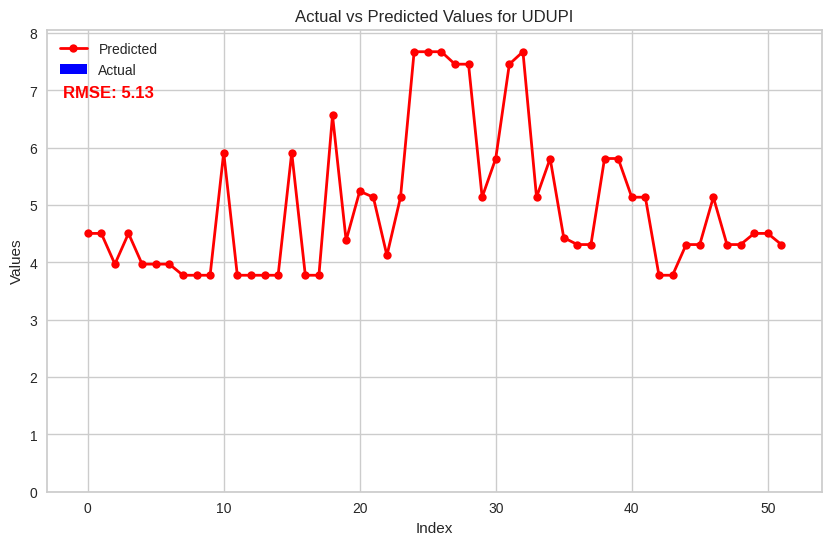

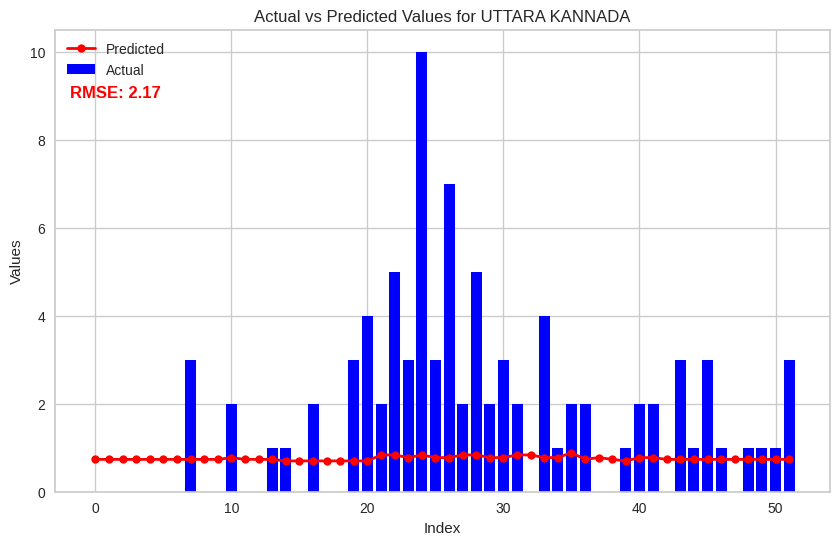

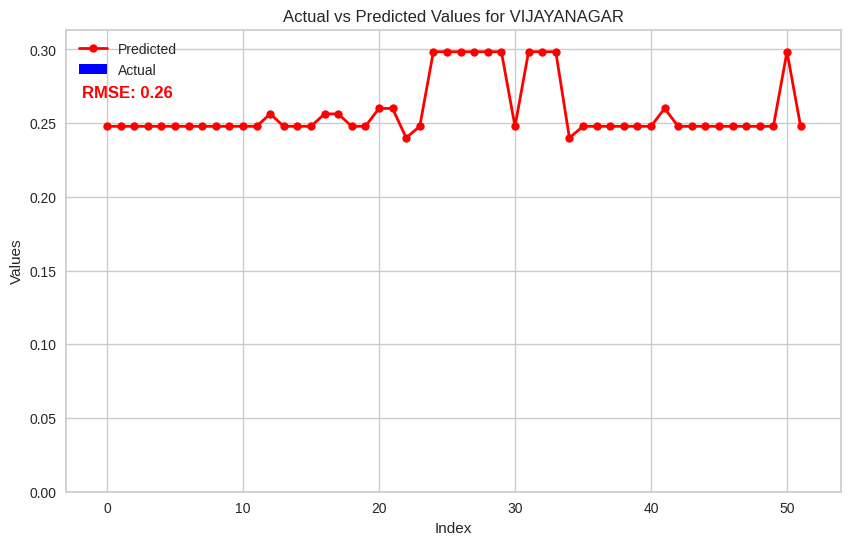

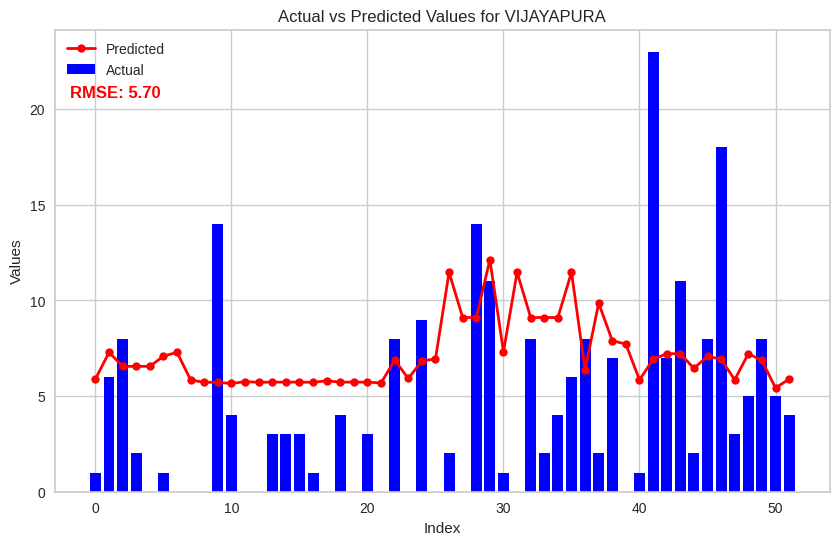

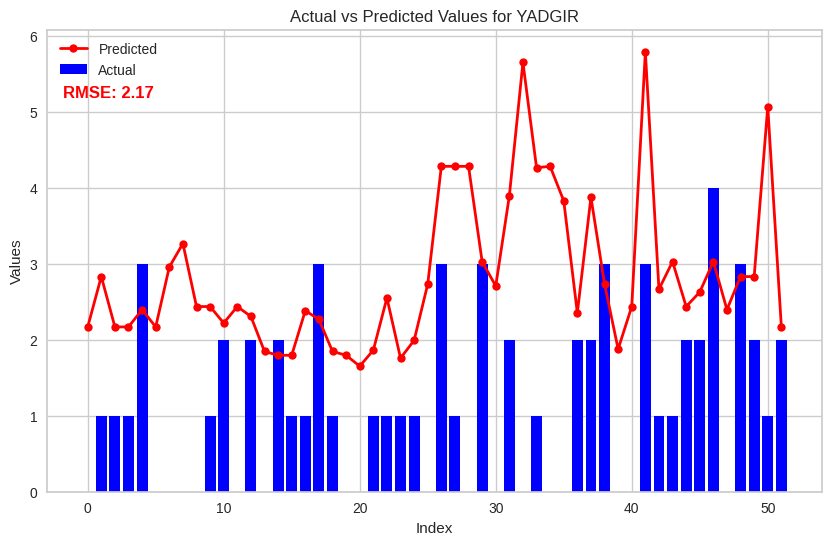

In [27]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


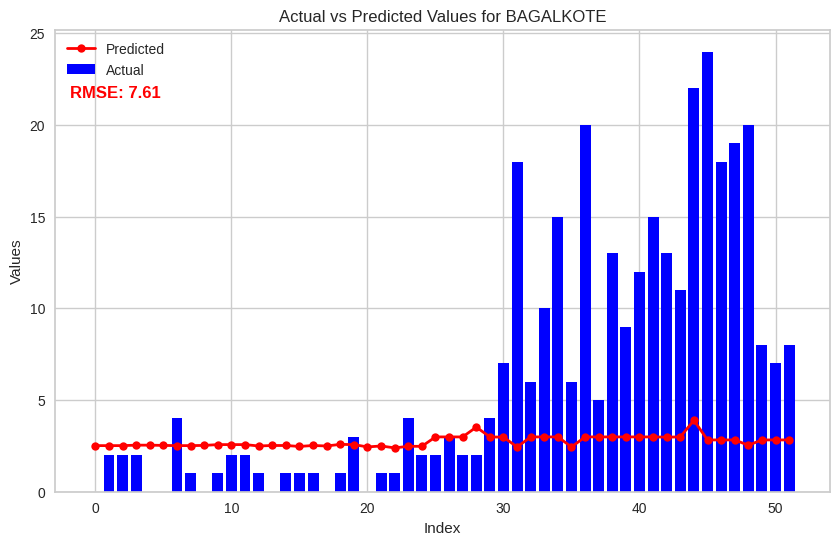

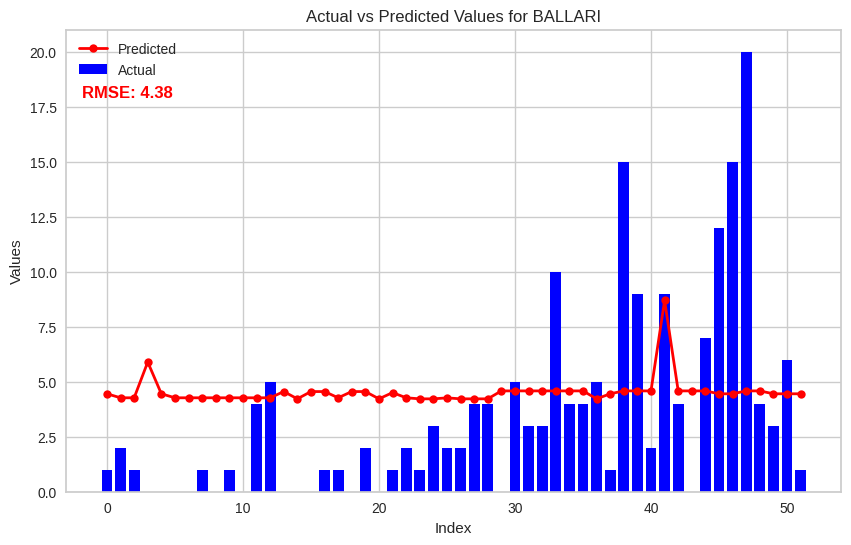

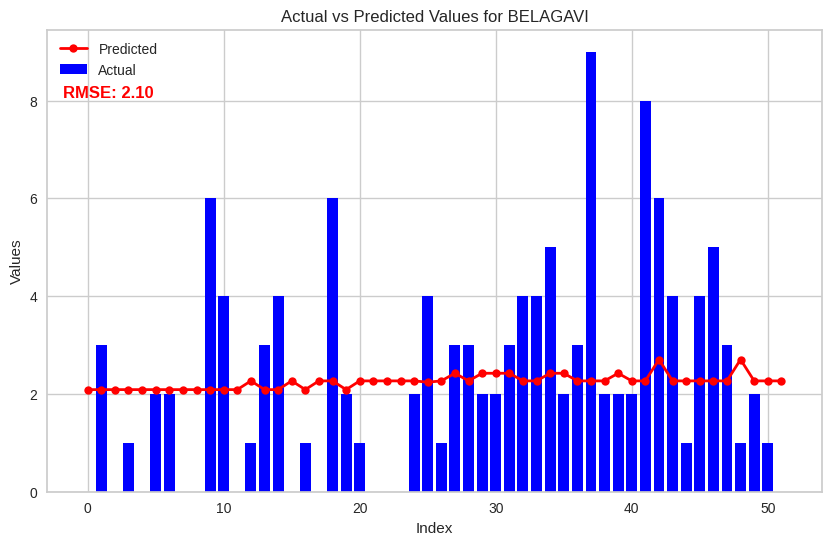

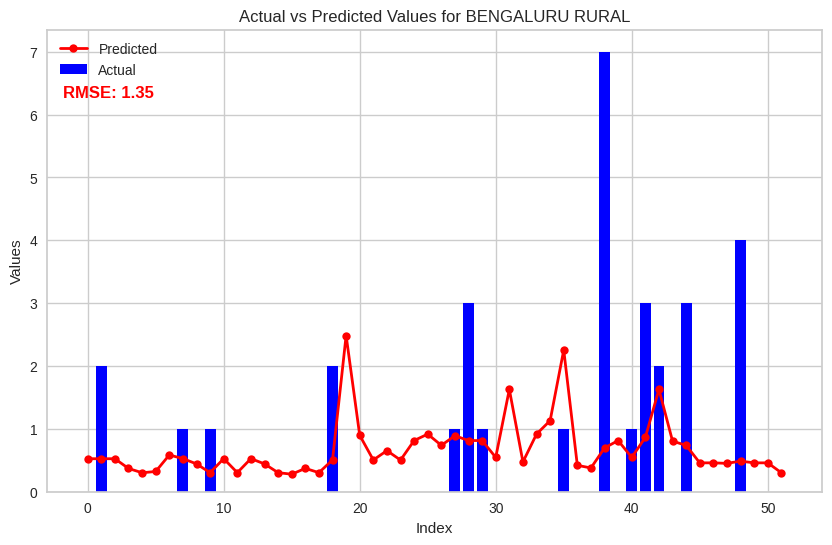

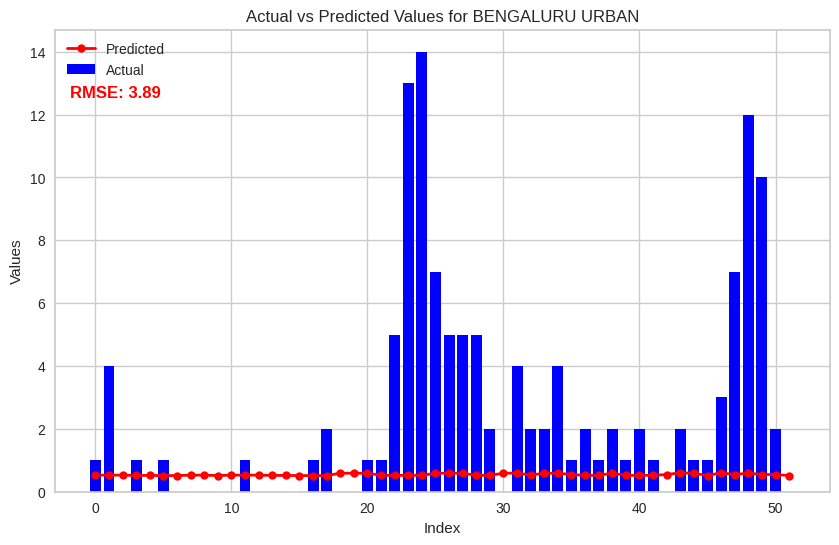

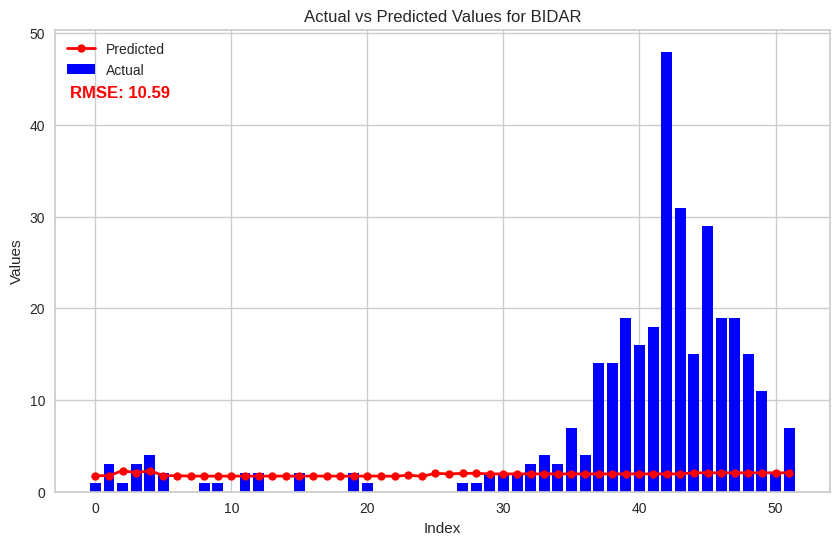

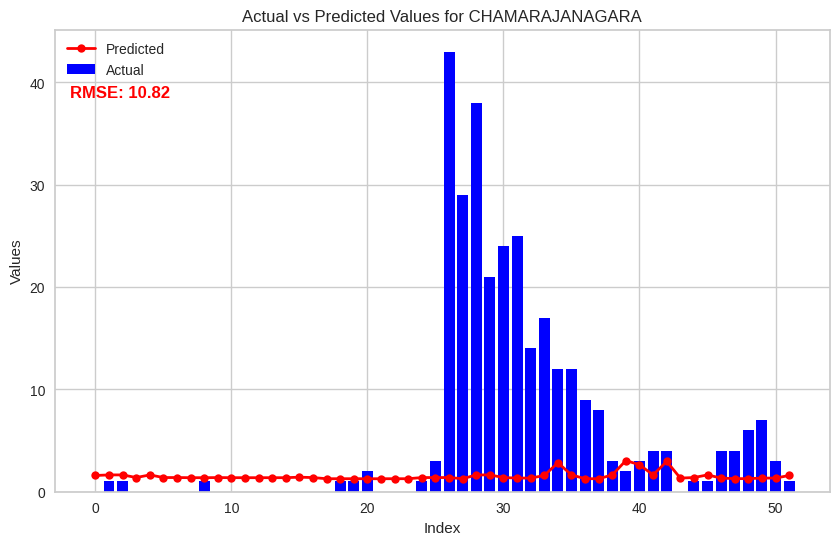

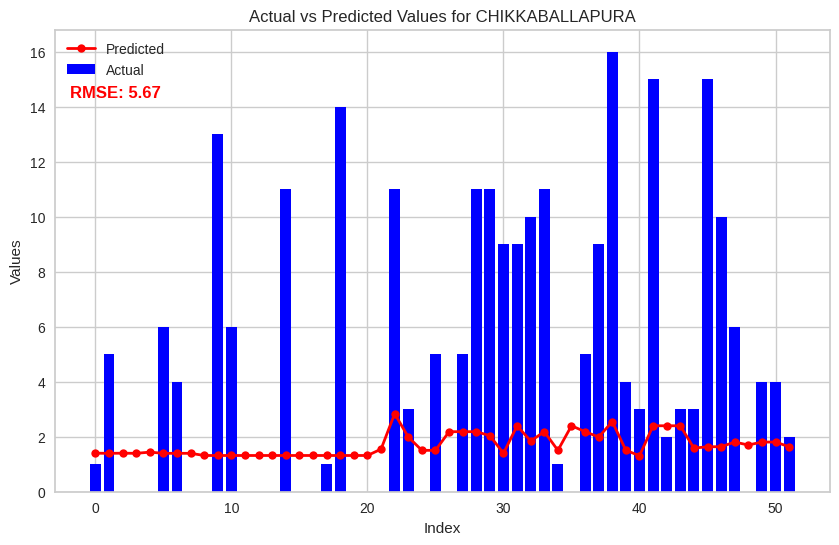

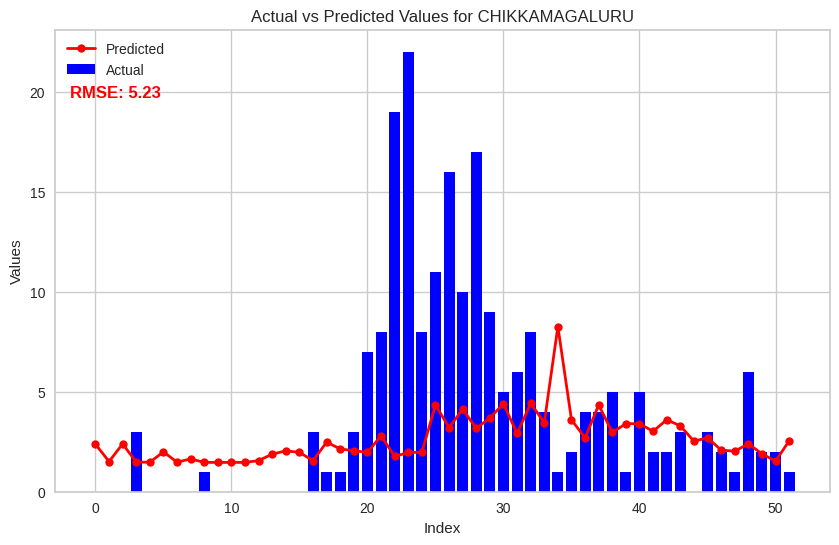

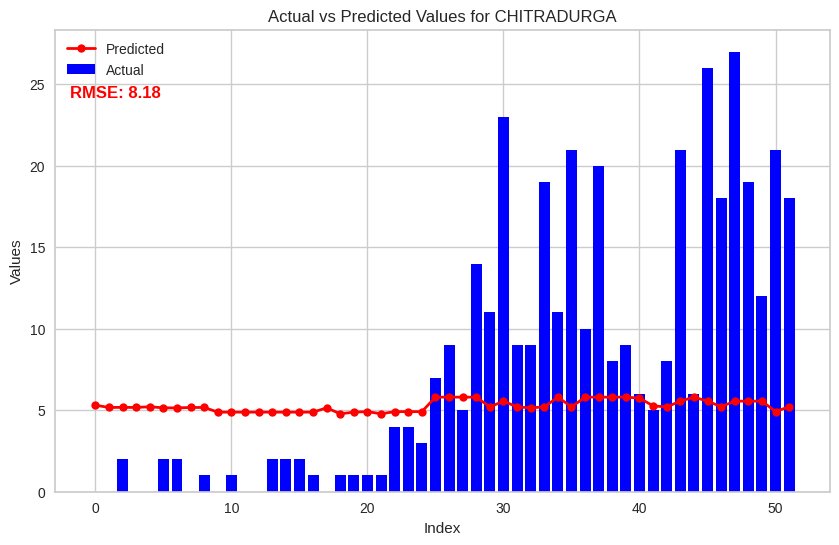

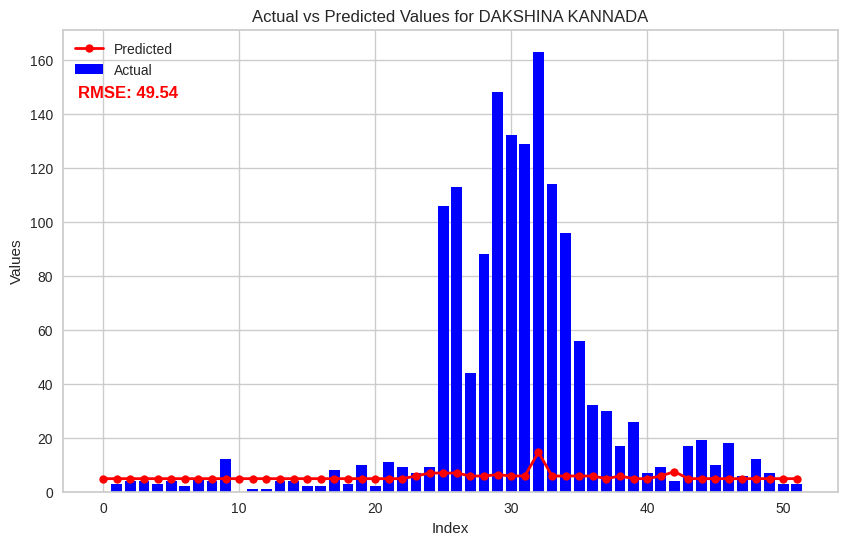

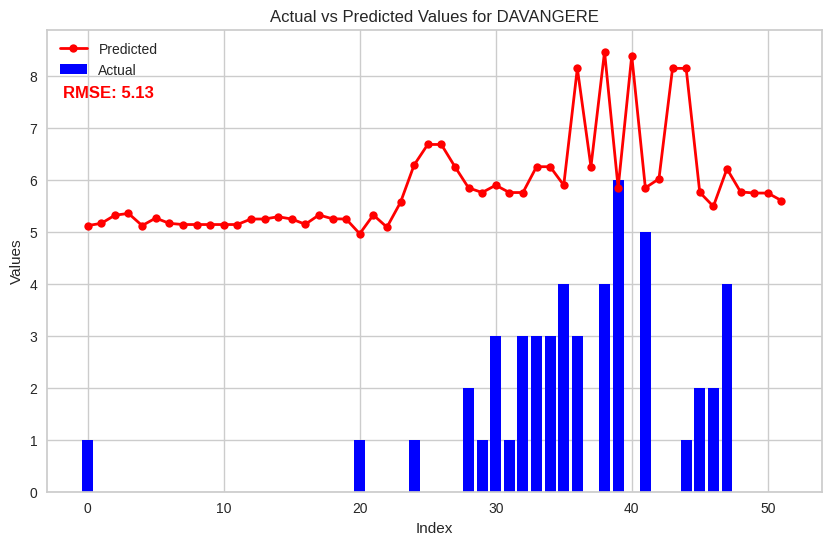

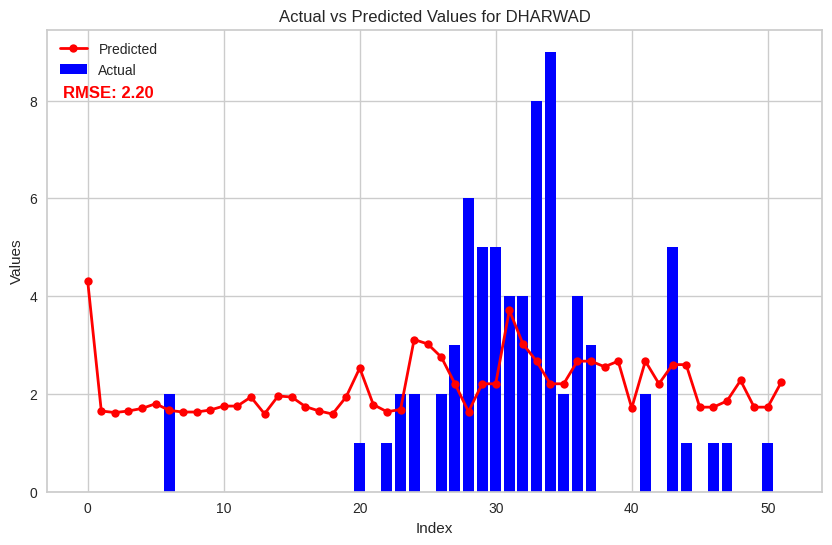

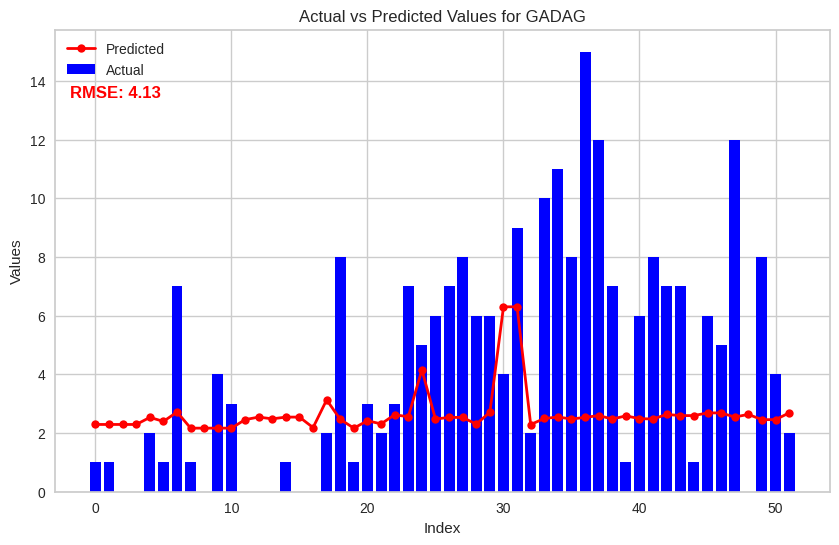

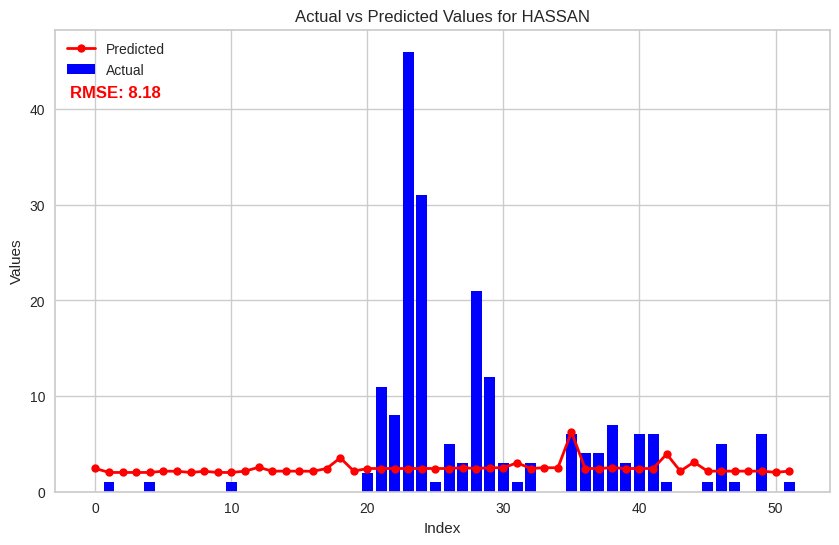

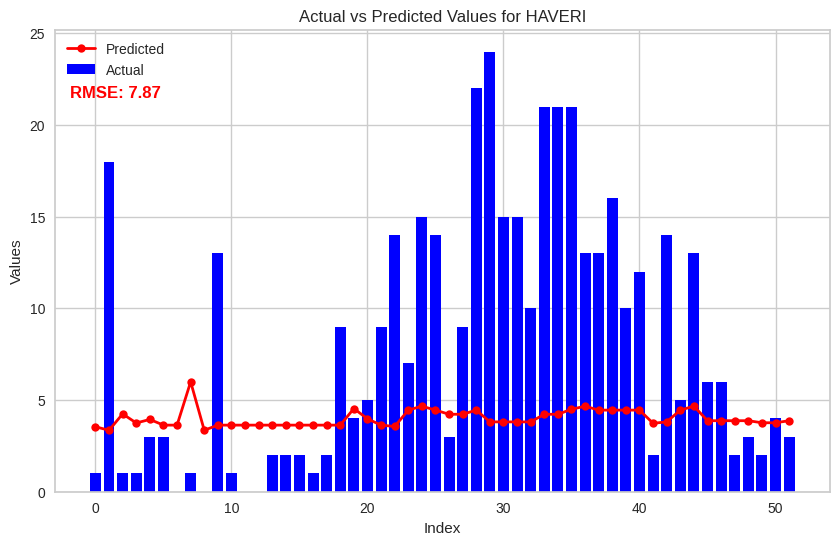

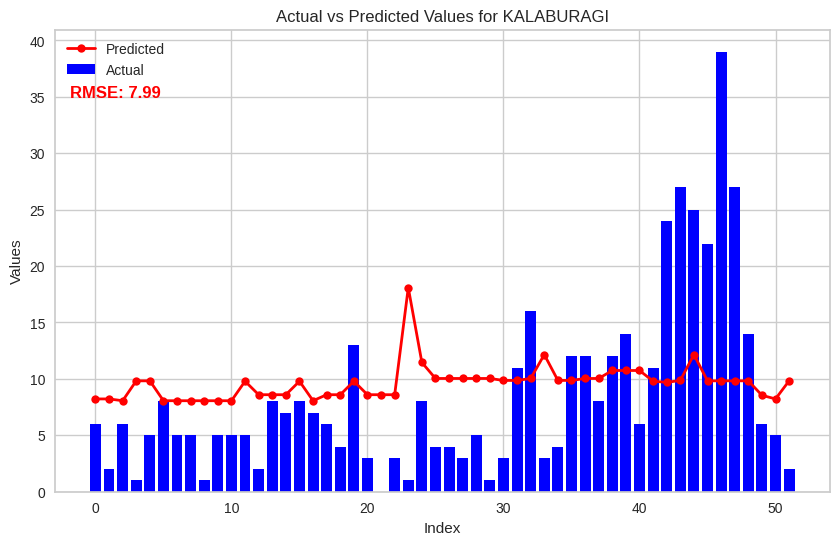

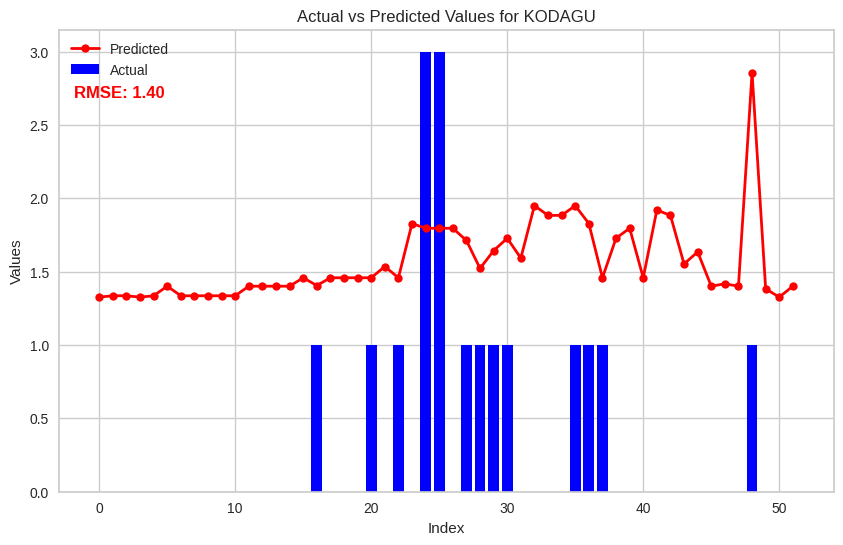

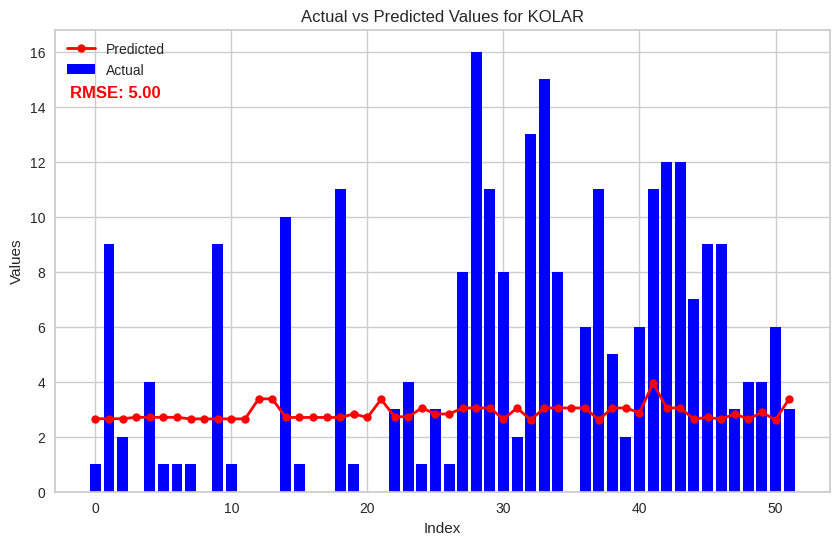

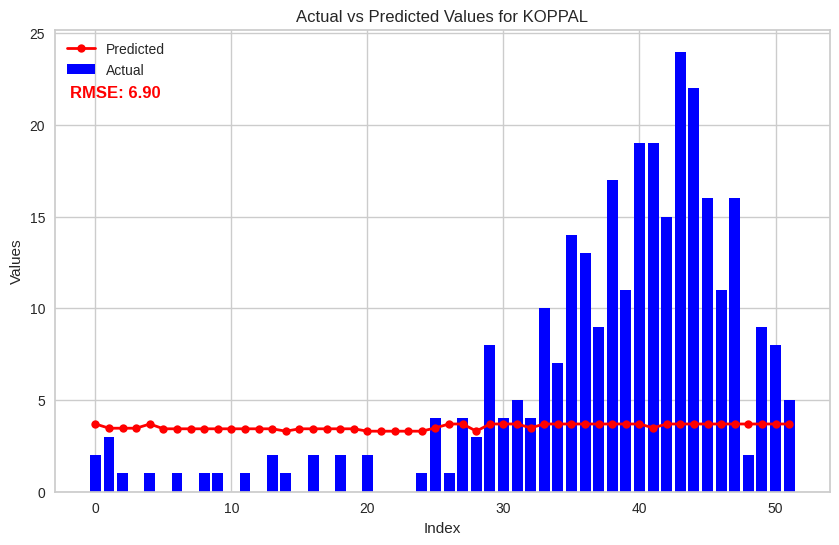

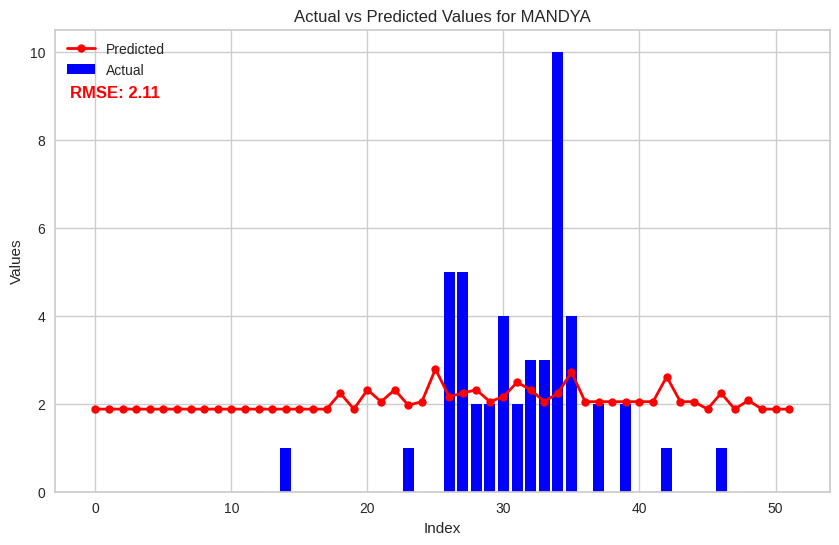

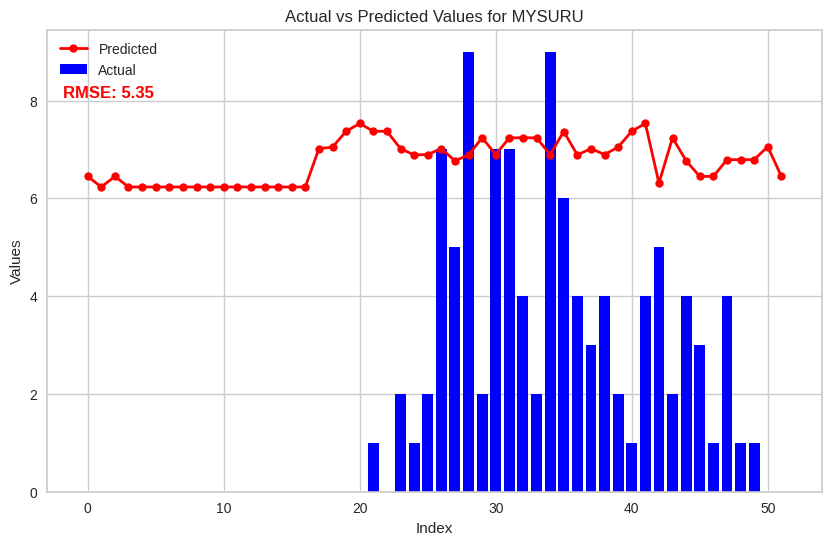

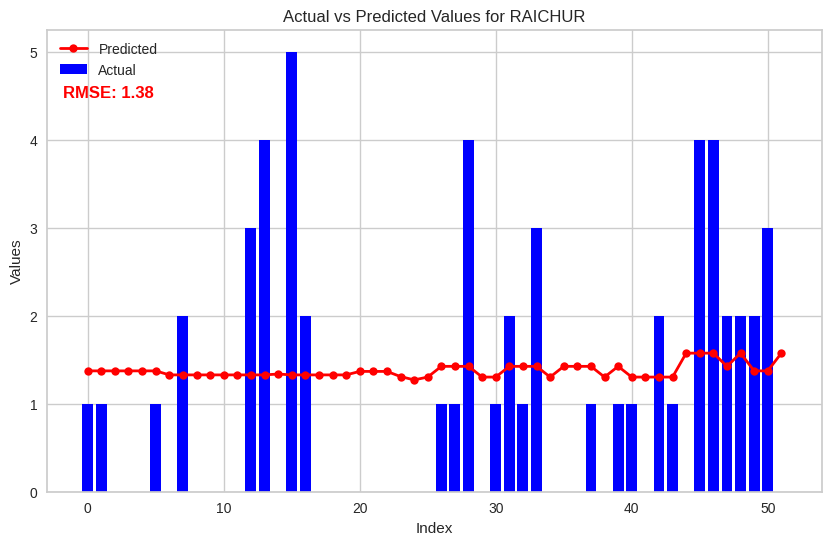

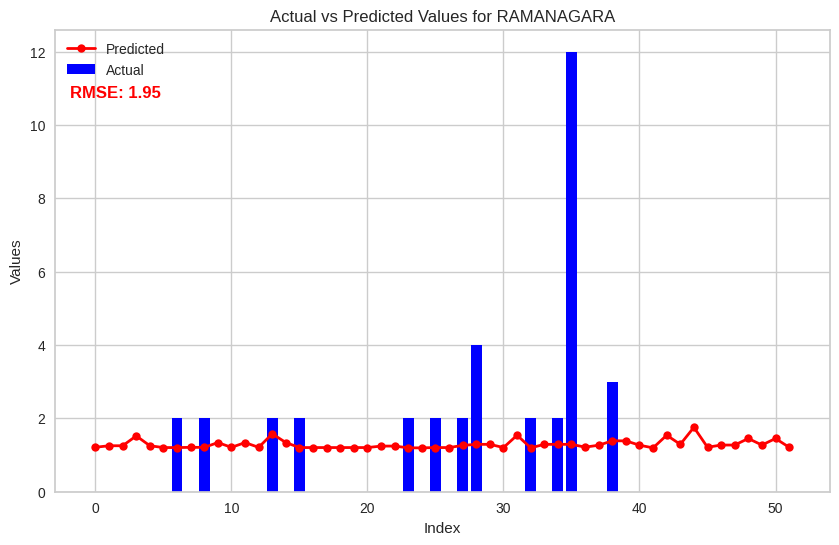

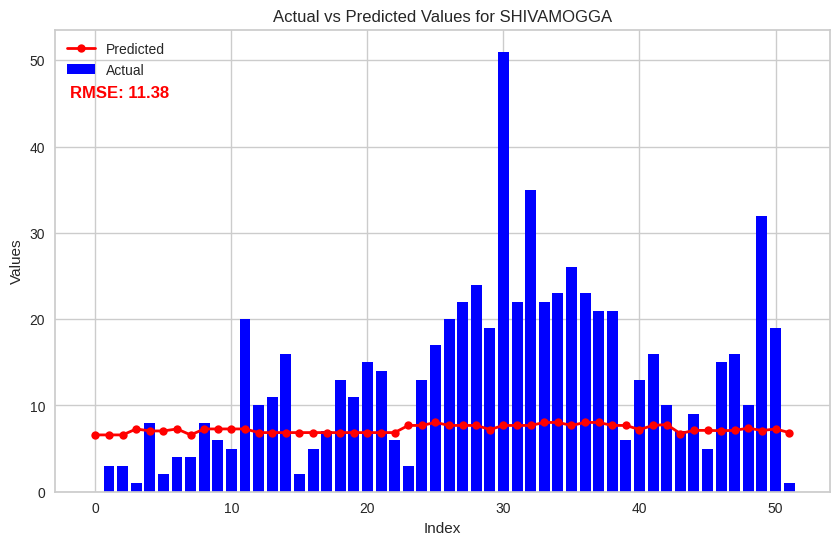

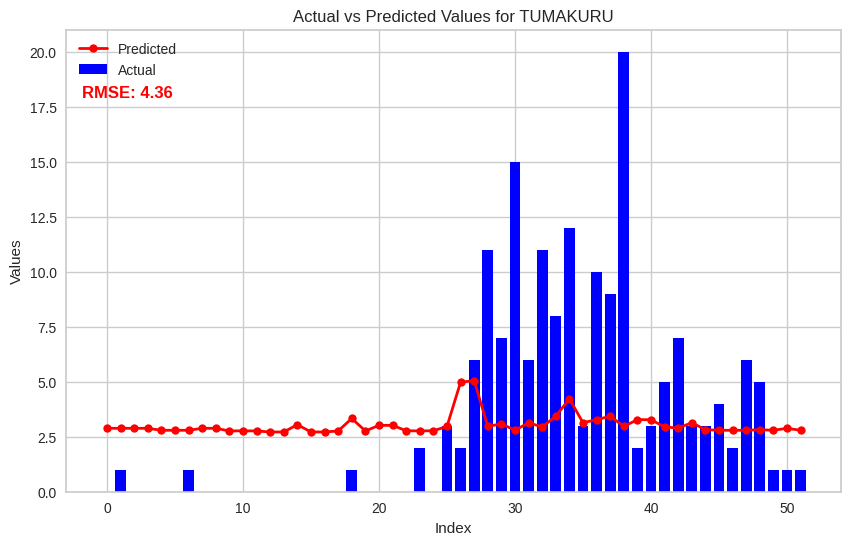

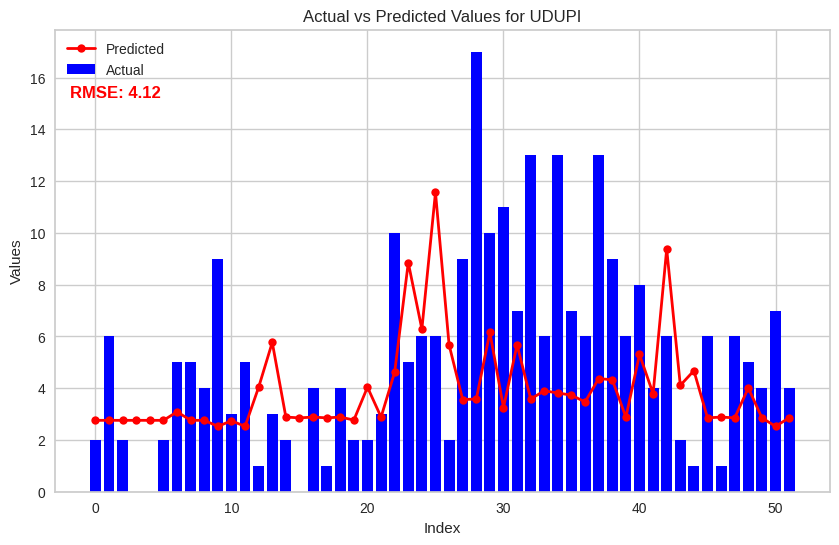

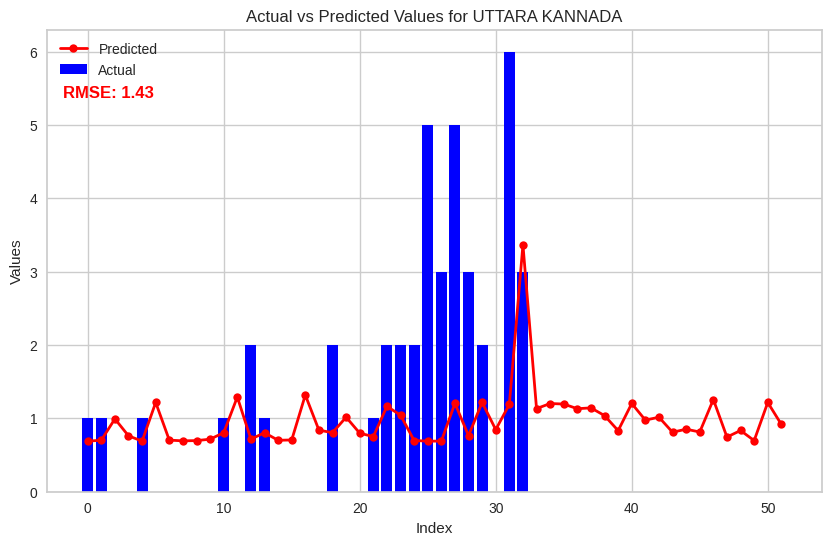

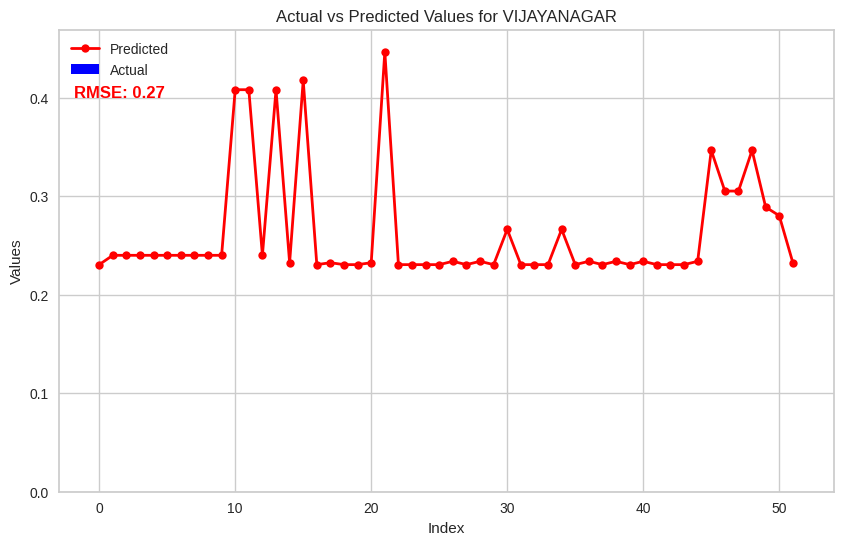

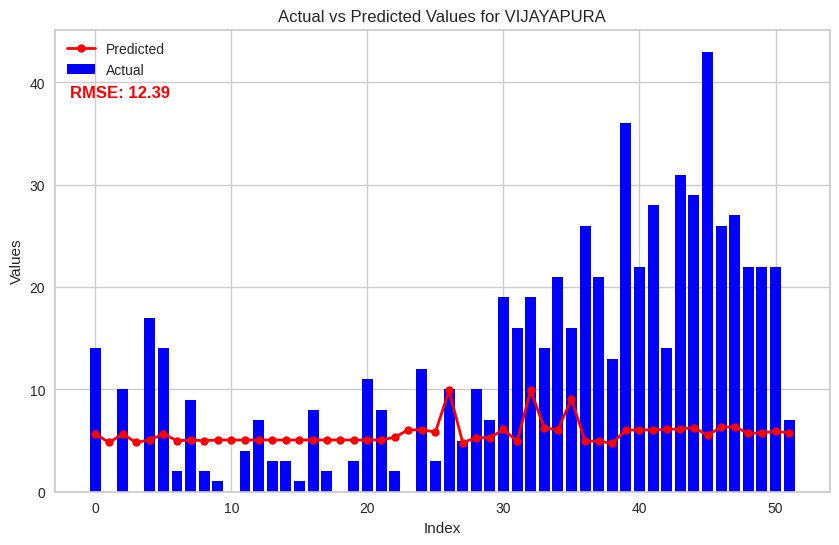

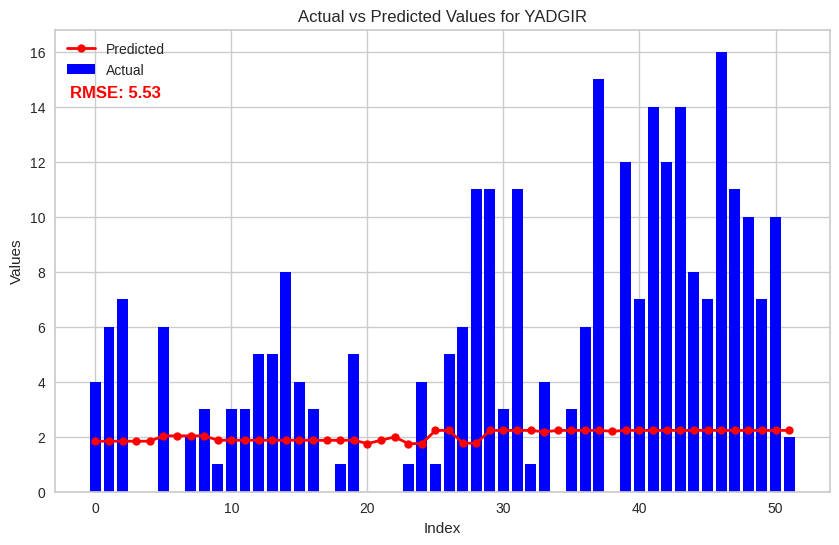

In [28]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


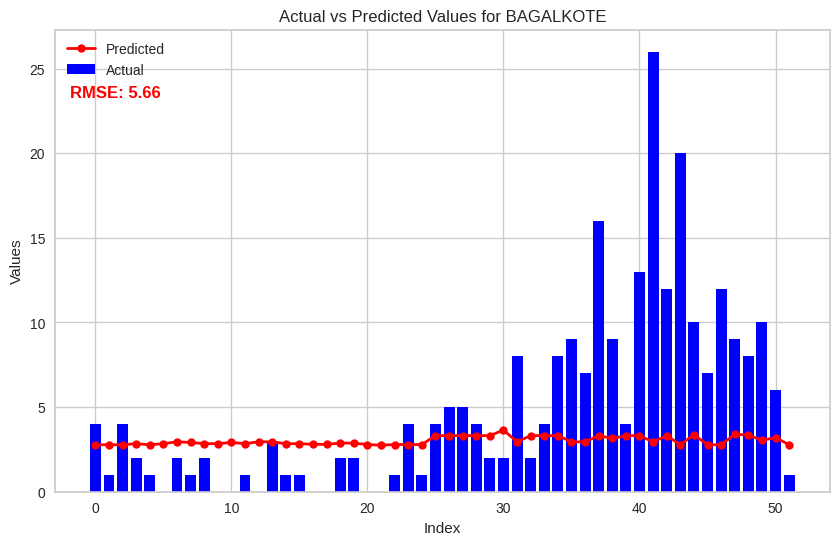

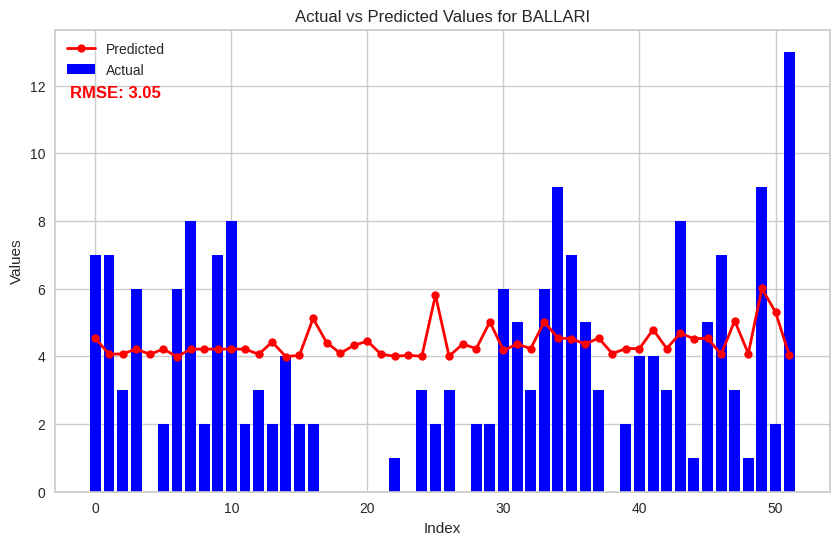

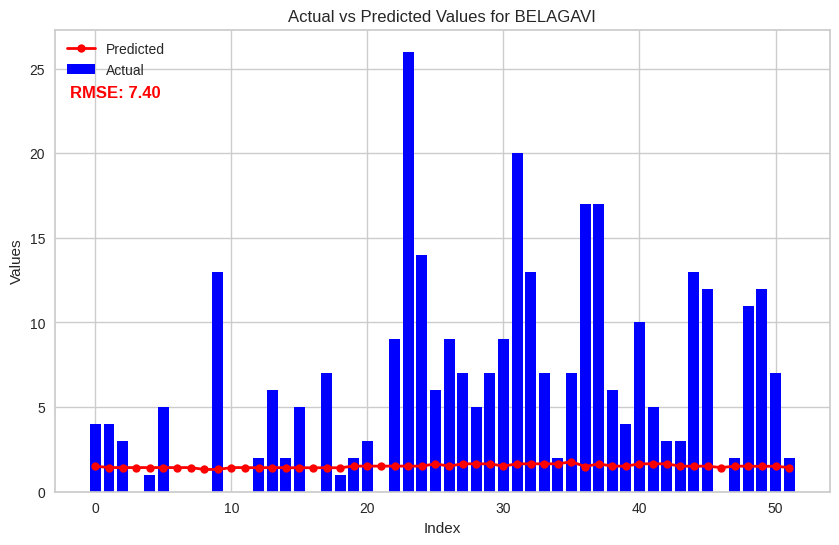

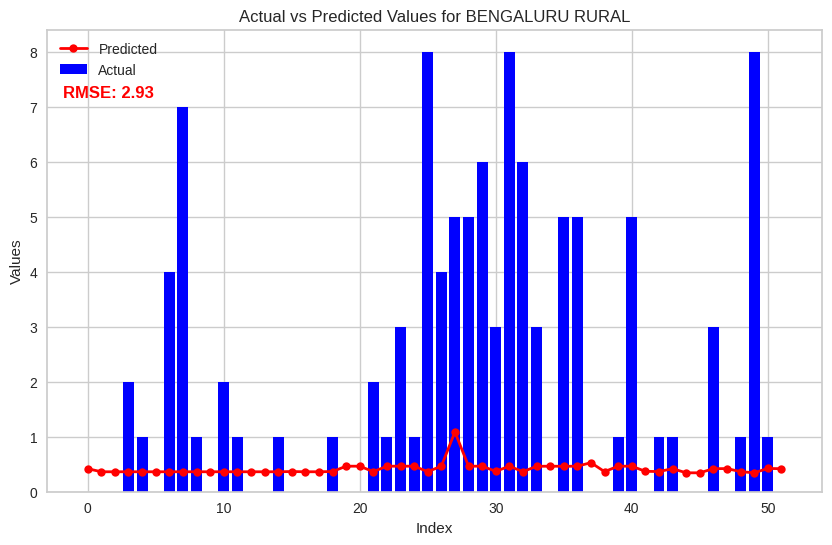

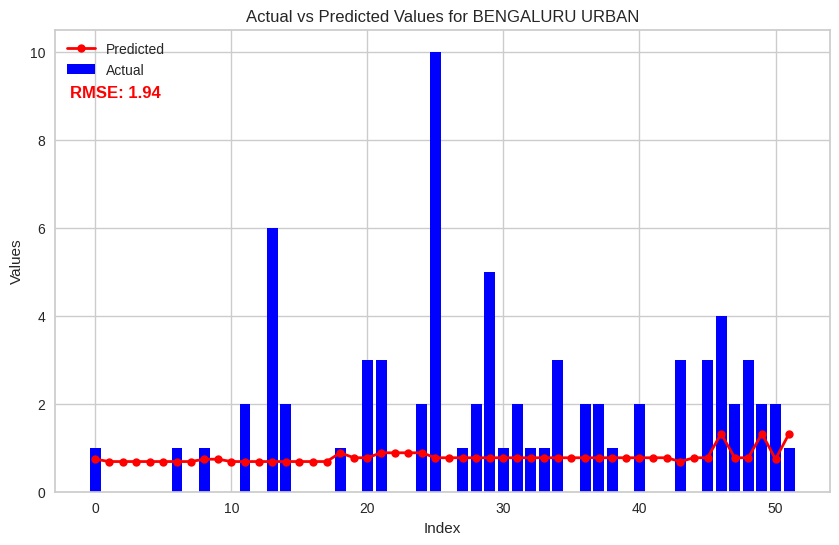

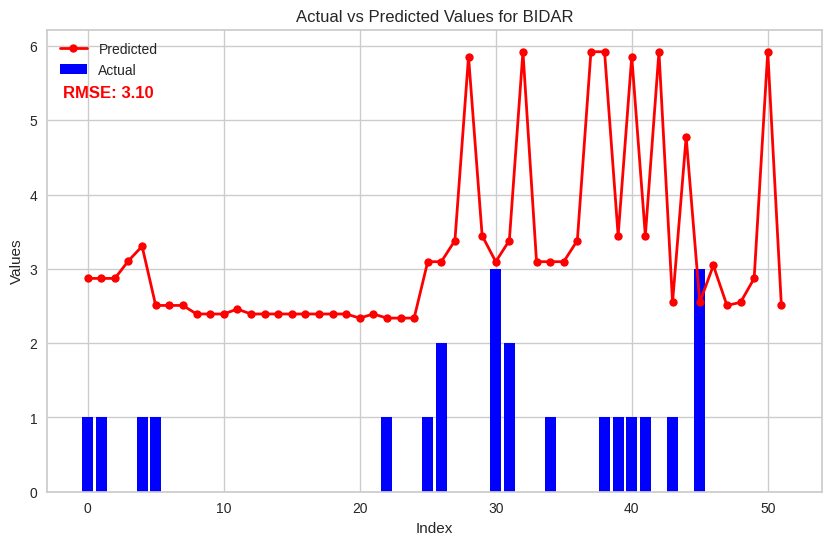

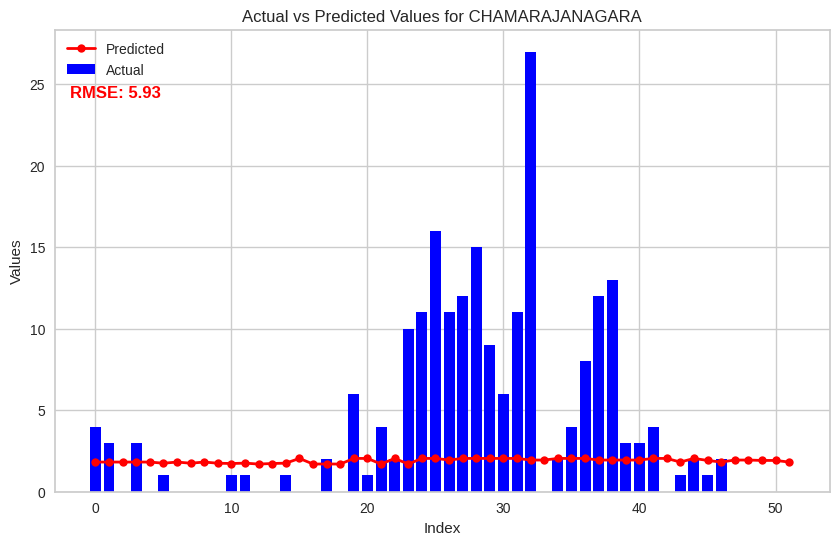

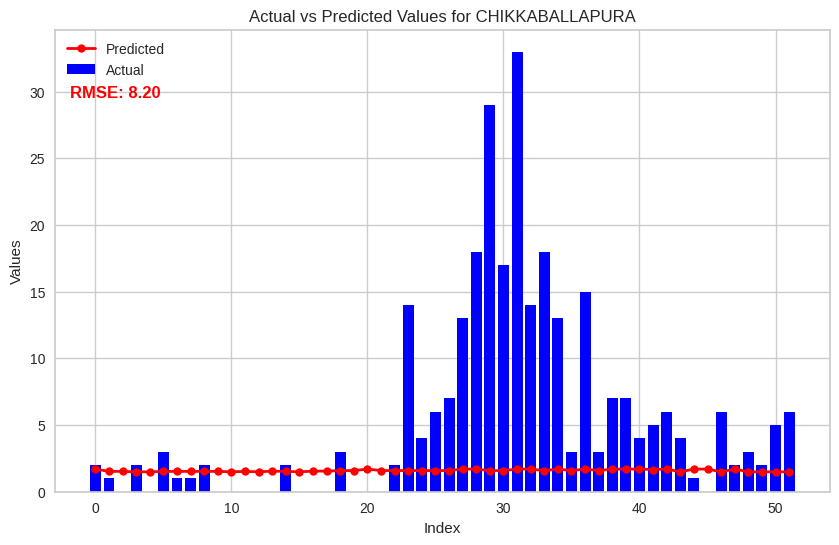

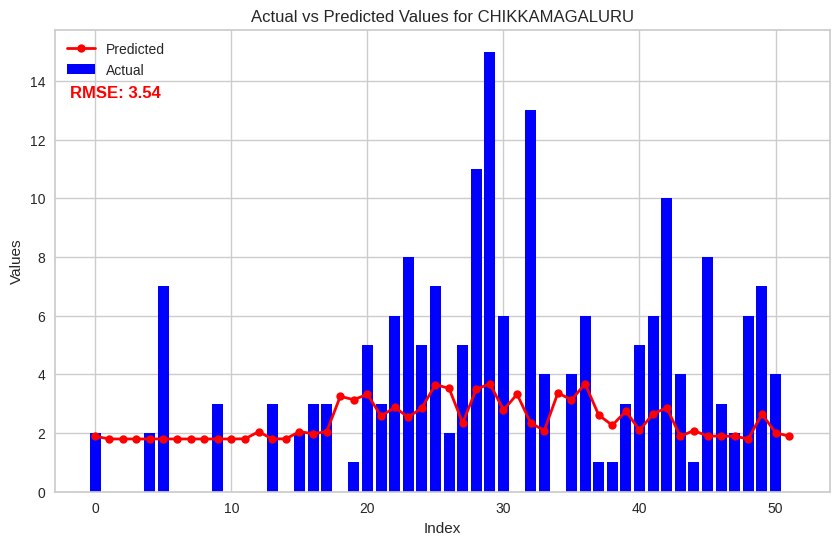

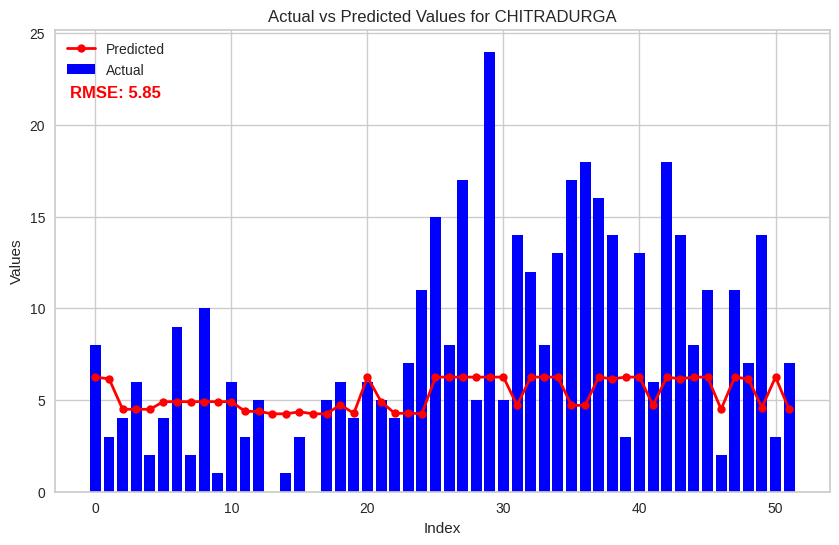

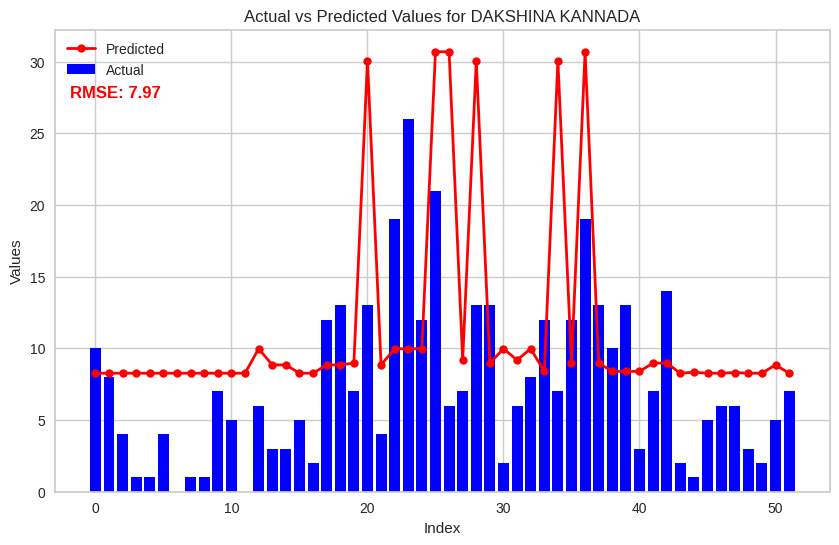

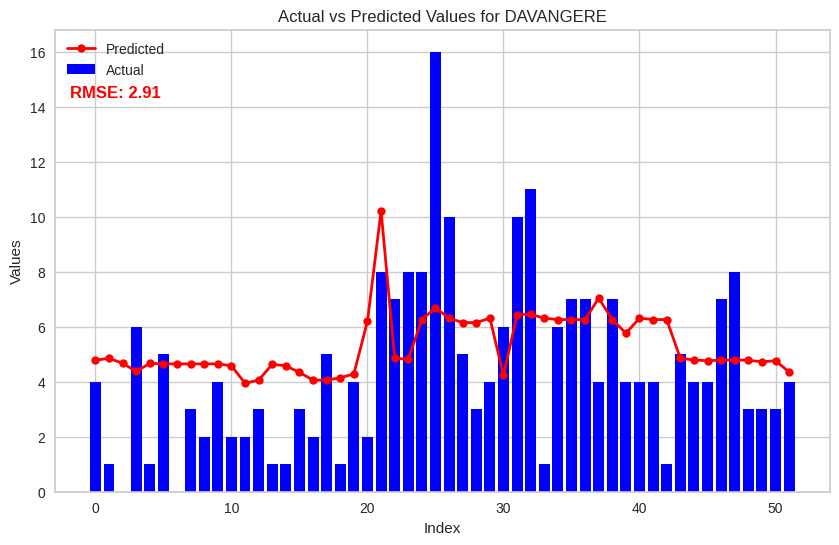

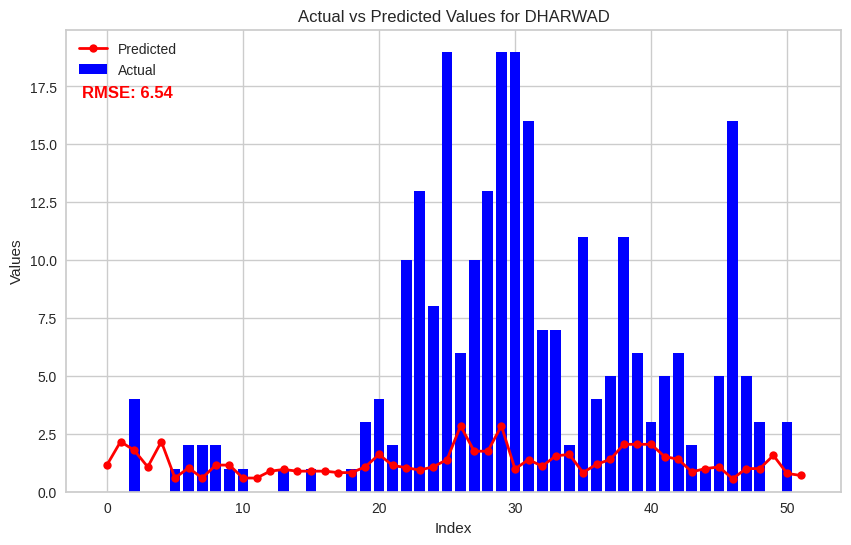

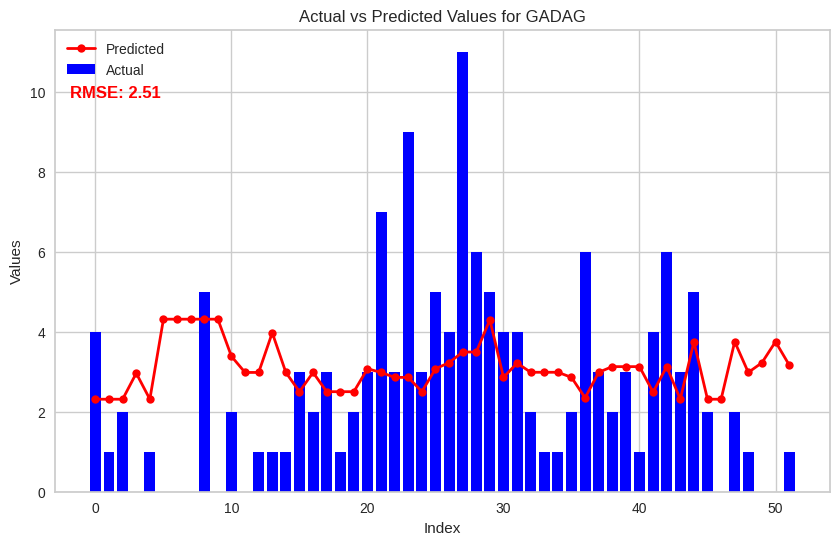

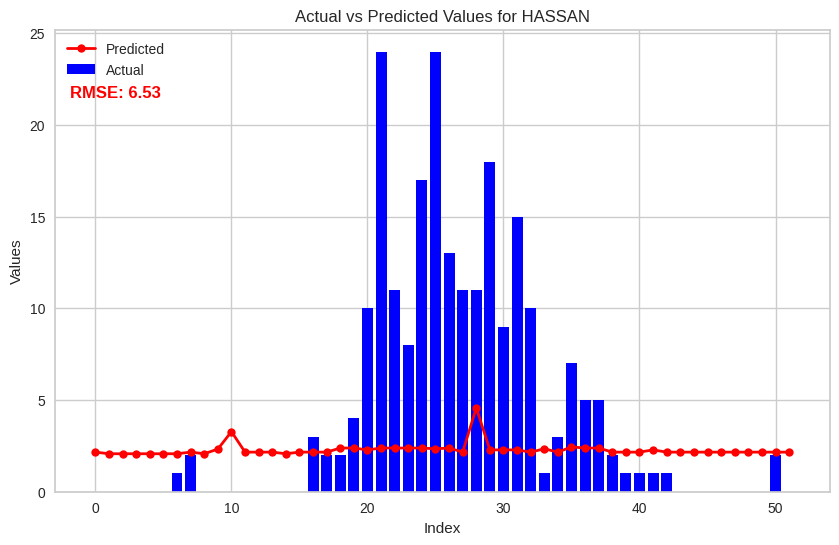

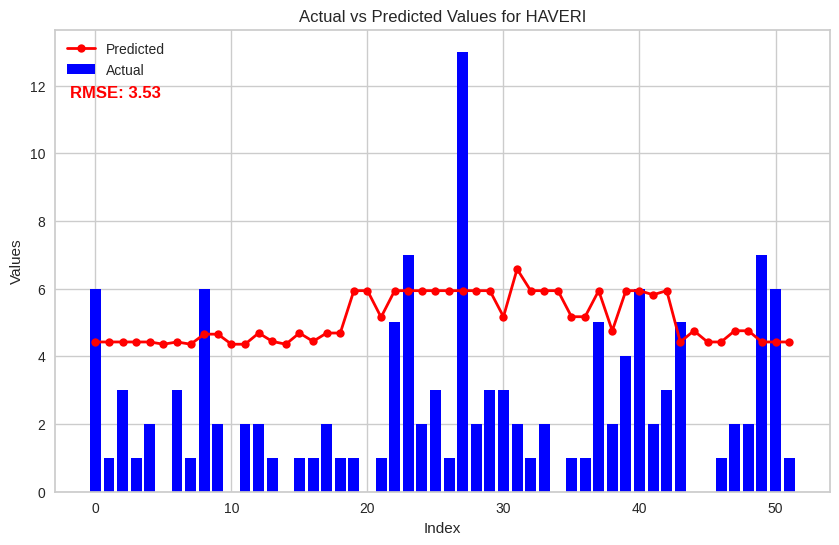

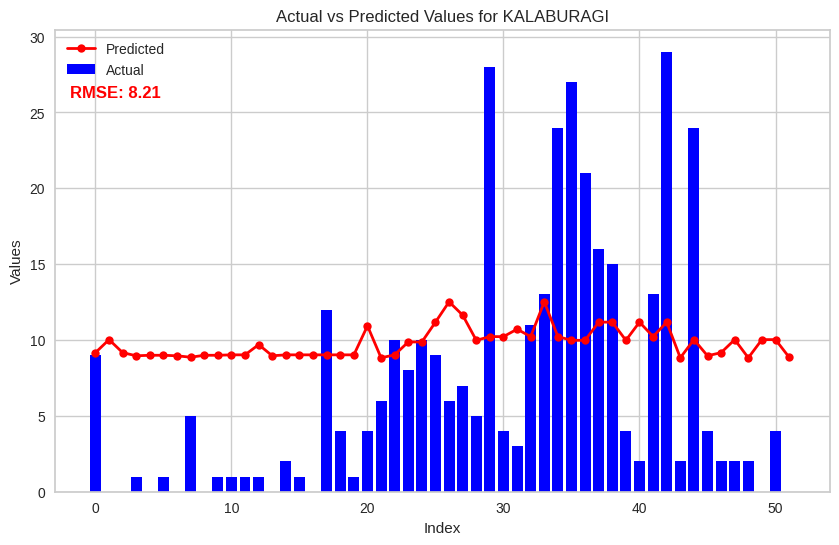

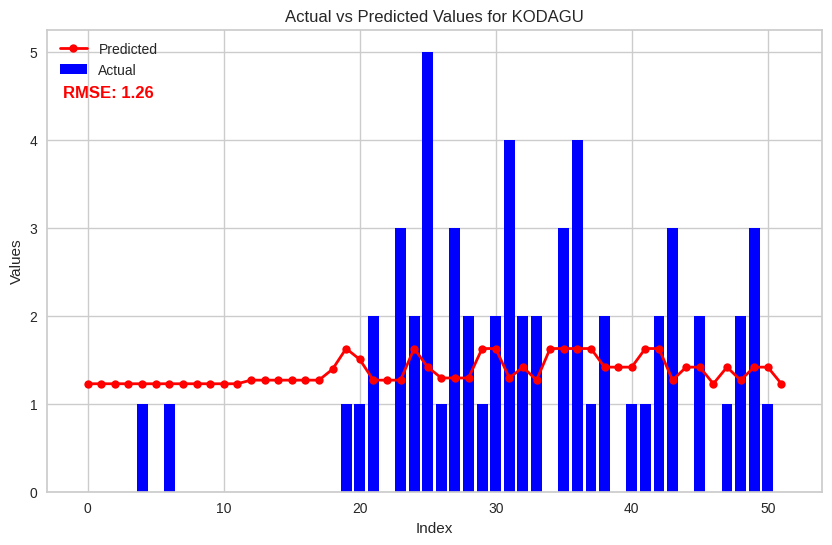

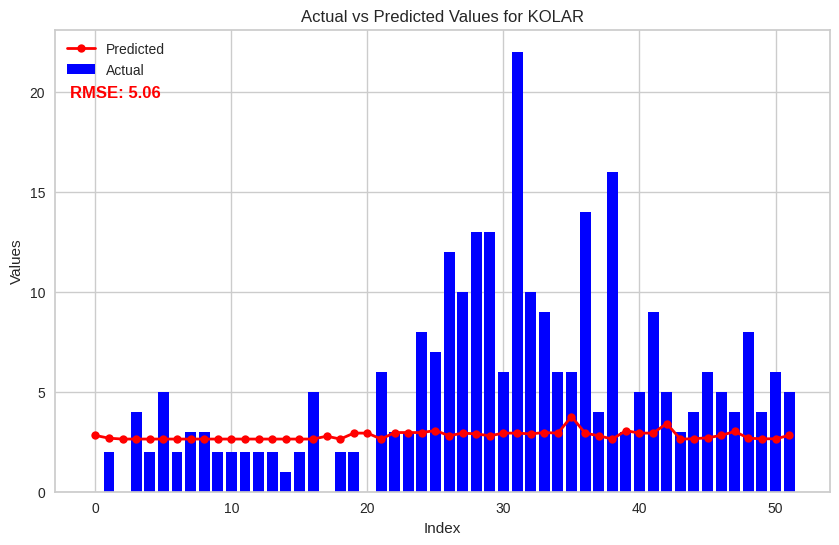

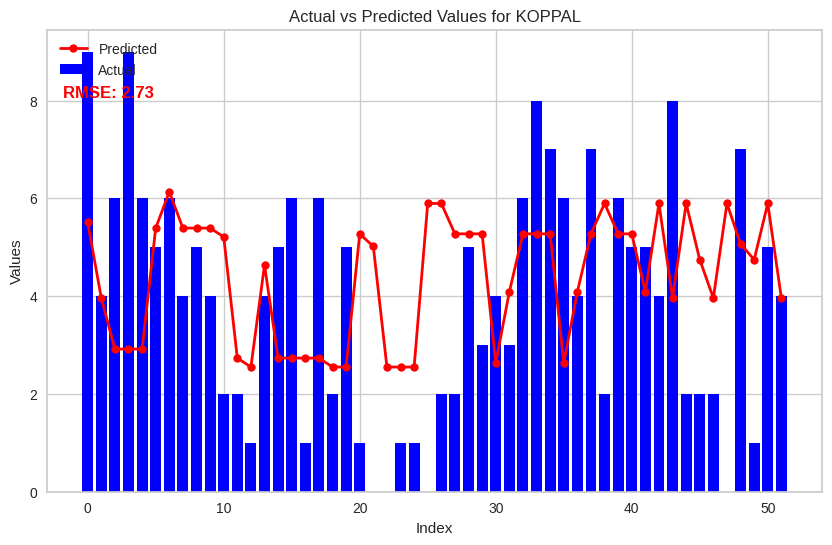

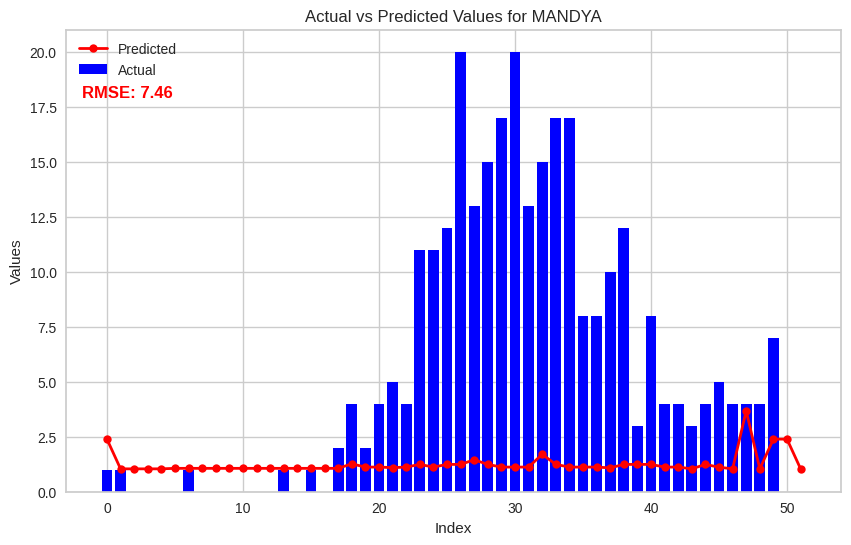

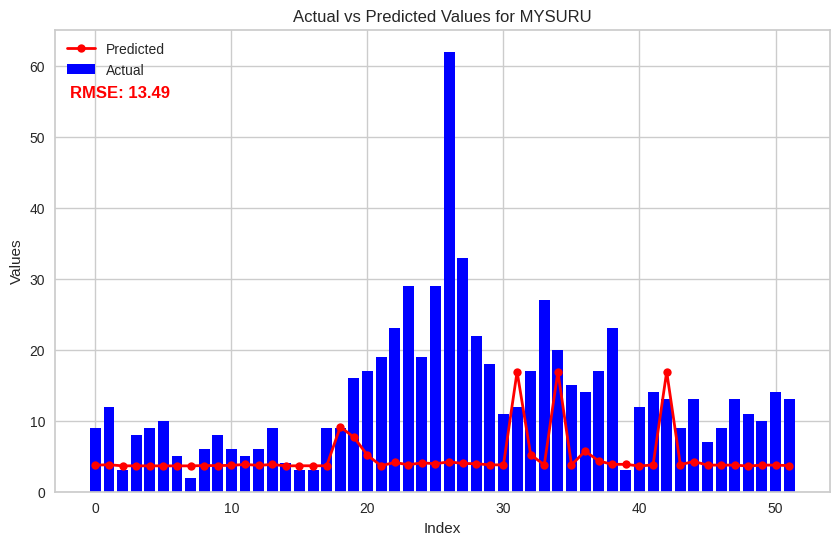

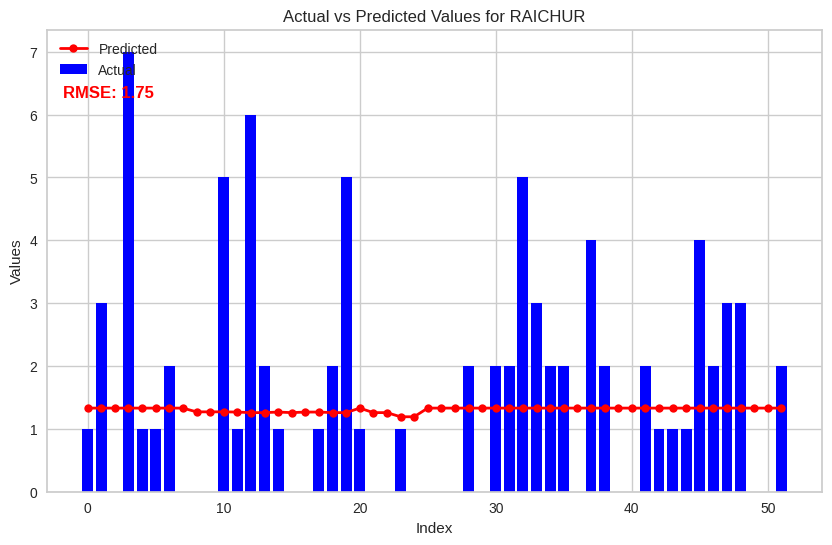

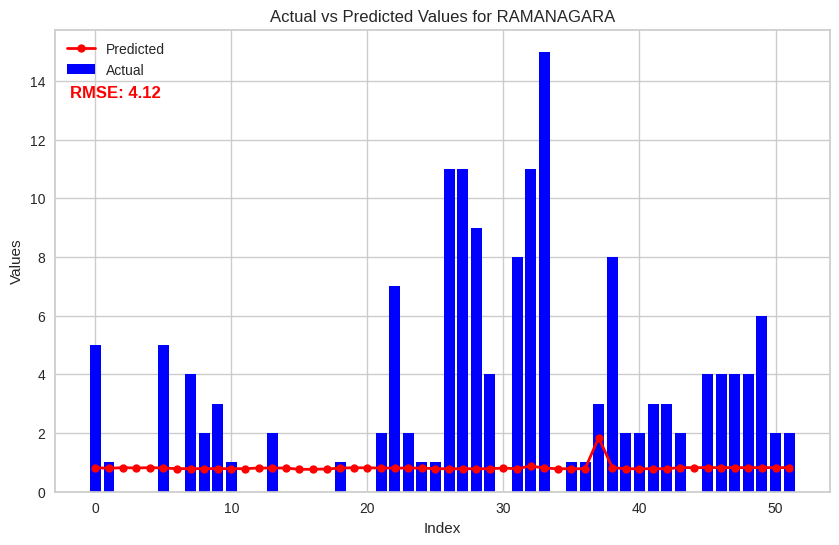

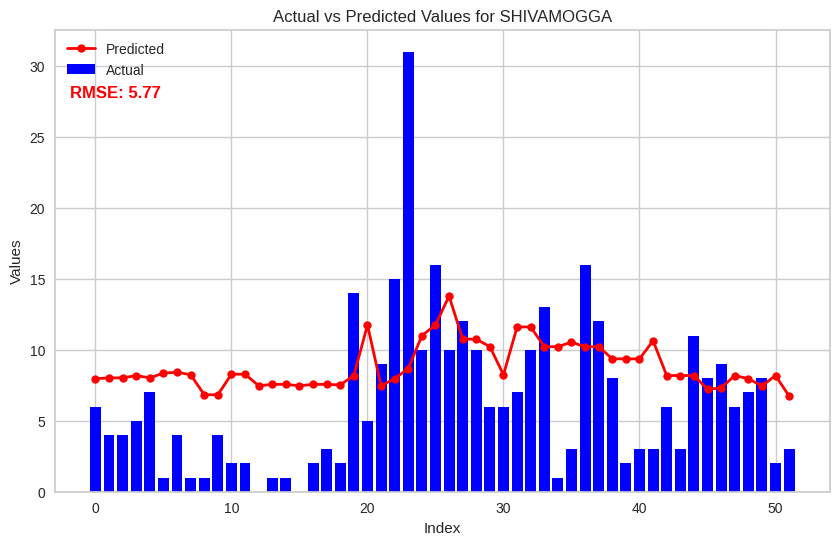

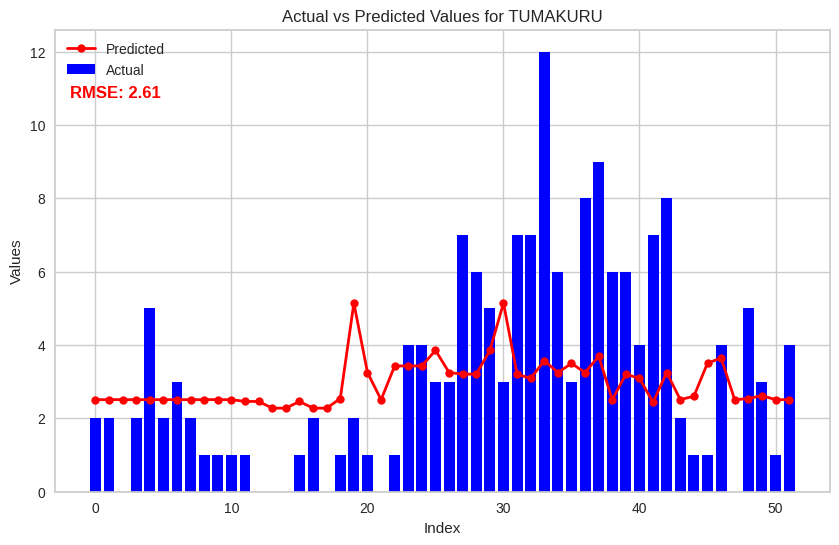

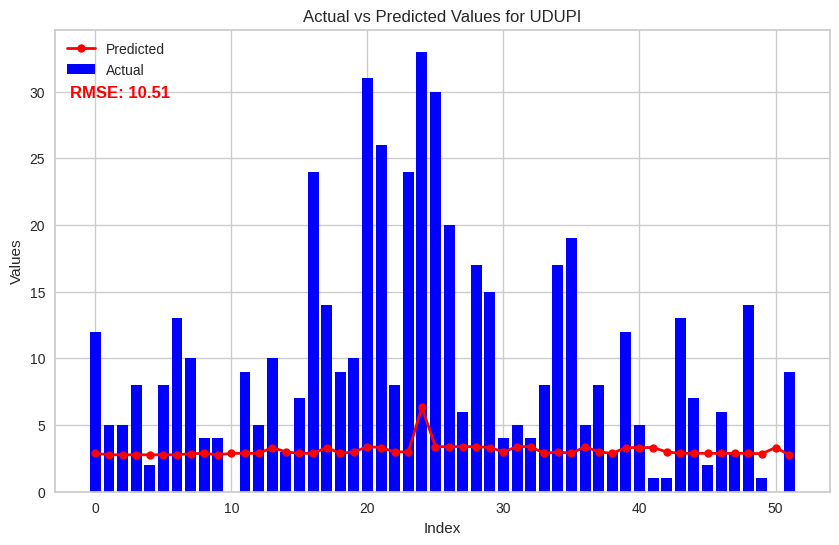

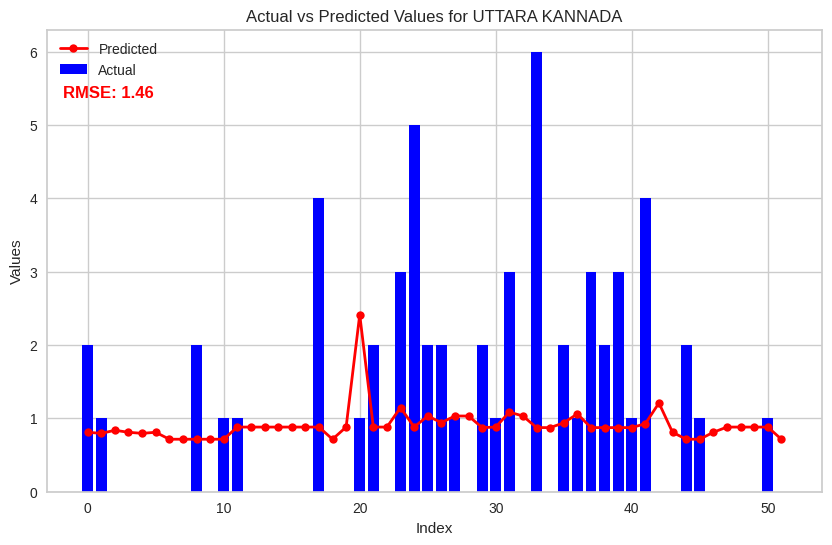

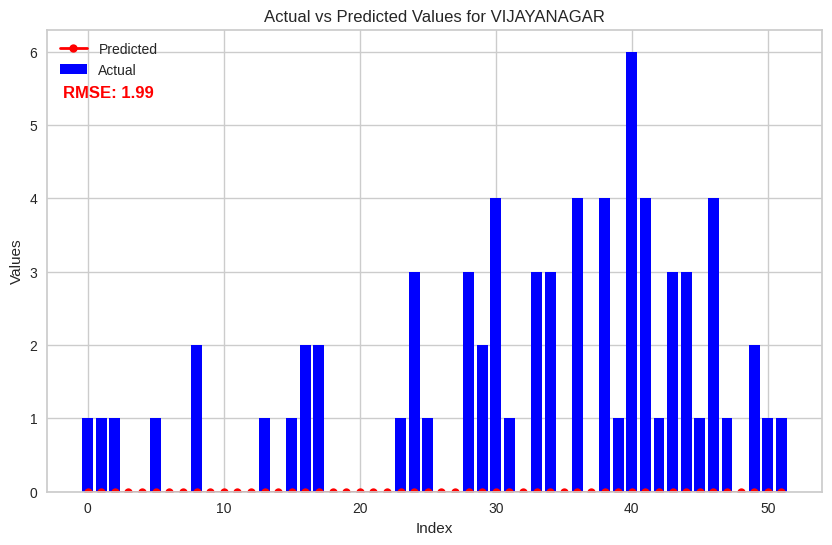

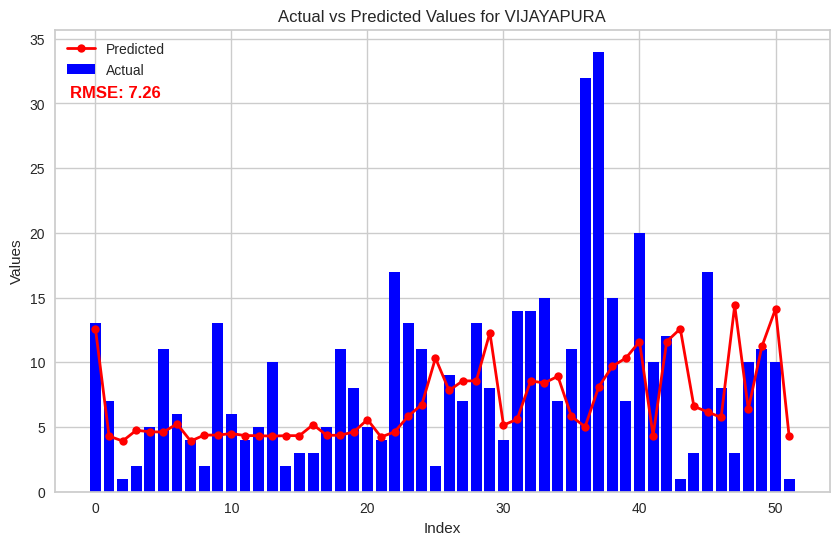

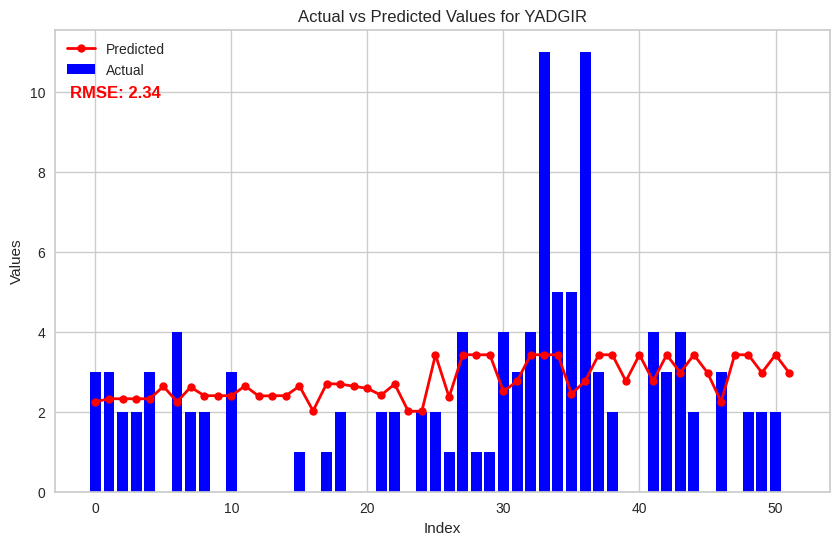

In [29]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis.analyze_districts()

In [30]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.234241              Bad   3.129612              Bad   
1            BALLARI  10.502236              Bad   4.464778              Bad   
2           BELAGAVI   2.209255              Bad   1.895416             Good   
3    BENGALURU RURAL   0.639646             Good   0.755582             Good   
4    BENGALURU URBAN   1.094037             Good   1.093762             Good   
5              BIDAR   5.405669              Bad   3.430493              Bad   
6    CHAMARAJANAGARA   2.825582              Bad   2.095509              Bad   
7    CHIKKABALLAPURA   2.394156              Bad   3.484261              Bad   
8     CHIKKAMAGALURU   6.975418              Bad   2.583900              Bad   
9        CHITRADURGA   9.184625              Bad   5.144739              Bad   
10  DAKSHINA KANNADA   9.905165              Bad  14.454581              Bad   
11         DAVANGERE  20.694094              Bad   3.775019              Bad   
12           DHARWAD   2.297937              Bad   2.217461              Bad   
13             GADAG   3.443890              Bad   2.428112              Bad   
14            HASSAN   3.003531              Bad   8.600875              Bad   
15            HAVERI   7.365400              Bad   3.091621              Bad   
16        KALABURAGI  29.376793              Bad  18.379155              Bad   
17            KODAGU   8.818438              Bad   1.336125             Good   
18             KOLAR   7.917589              Bad   3.615615              Bad   
19            KOPPAL   4.090355              Bad   4.379696              Bad   
20            MANDYA   2.416768              Bad   2.446757              Bad   
21            MYSURU  24.214070              Bad   6.021513              Bad   
22           RAICHUR   3.346089              Bad   1.946576             Good   
23        RAMANAGARA   8.381378              Bad   1.247667             Good   
24        SHIVAMOGGA  11.232453              Bad   4.915337              Bad   
25          TUMAKURU  15.751232              Bad   3.251601              Bad   
26             UDUPI   4.888595              Bad   5.134327              Bad   
27    UTTARA KANNADA   1.084932             Good   2.170184              Bad   
28       VIJAYANAGAR   0.261568             Good   0.259214             Good   
29        VIJAYAPURA   5.709152              Bad   5.697973              Bad   
30            YADGIR   2.329667              Bad   2.166489              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    7.612699              Bad   5.658976              Bad  
1    4.380354              Bad   3.046054              Bad  
2    2.103539              Bad   7.396384              Bad  
3    1.346611             Good   2.926979              Bad  
4    3.888161              Bad   1.941406             Good  
5   10.589023              Bad   3.102577              Bad  
6   10.818473              Bad   5.930057              Bad  
7    5.667386              Bad   8.196902              Bad  
8    5.231084              Bad   3.540245              Bad  
9    8.180442              Bad   5.849357              Bad  
10  49.537891              Bad   7.970855              Bad  
11   5.125430              Bad   2.907909              Bad  
12   2.197078              Bad   6.540063              Bad  
13   4.126870              Bad   2.511471              Bad  
14   8.182983              Bad   6.529813              Bad  
15   7.871957              Bad   3.527215              Bad  
16   7.993572              Bad   8.213635              Bad  
17   1.395104             Good   1.264246             Good  
18   4.998688              Bad   5.058979              Bad  
19   6.897163              Bad   2.728982              Bad  
20   2.107298              Bad   7.460175              Bad  
21   5.353756              Bad  13.490388              Bad  
22   1.380897             Good   1.745765       

In [31]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.23              Bad       3.13              Bad   
1            BALLARI      10.50              Bad       4.46              Bad   
2           BELAGAVI       2.21              Bad       1.90             Good   
3    BENGALURU RURAL       0.64             Good       0.76             Good   
4    BENGALURU URBAN       1.09             Good       1.09             Good   
5              BIDAR       5.41              Bad       3.43              Bad   
6    CHAMARAJANAGARA       2.83              Bad       2.10              Bad   
7    CHIKKABALLAPURA       2.39              Bad       3.48              Bad   
8     CHIKKAMAGALURU       6.98              Bad       2.58              Bad   
9        CHITRADURGA       9.18              Bad       5.14              Bad   
10  DAKSHINA KANNADA       9.91              Bad      14.45              Bad   
11         DAVANGERE      20.69              Bad       3.78              Bad   
12           DHARWAD       2.30              Bad       2.22              Bad   
13             GADAG       3.44              Bad       2.43              Bad   
14            HASSAN       3.00              Bad       8.60              Bad   
15            HAVERI       7.37              Bad       3.09              Bad   
16        KALABURAGI      29.38              Bad      18.38              Bad   
17            KODAGU       8.82              Bad       1.34             Good   
18             KOLAR       7.92              Bad       3.62              Bad   
19            KOPPAL       4.09              Bad       4.38              Bad   
20            MANDYA       2.42              Bad       2.45              Bad   
21            MYSURU      24.21              Bad       6.02              Bad   
22           RAICHUR       3.35              Bad       1.95             Good   
23        RAMANAGARA       8.38              Bad       1.25             Good   
24        SHIVAMOGGA      11.23              Bad       4.92              Bad   
25          TUMAKURU      15.75              Bad       3.25              Bad   
26             UDUPI       4.89              Bad       5.13              Bad   
27    UTTARA KANNADA       1.08             Good       2.17              Bad   
28       VIJAYANAGAR       0.26             Good       0.26             Good   
29        VIJAYAPURA       5.71              Bad       5.70              Bad   
30            YADGIR       2.33              Bad       2.17              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.61              Bad       5.66              Bad  
1        4.38              Bad       3.05              Bad  
2        2.10              Bad       7.40              Bad  
3        1.35             Good       2.93              Bad  
4        3.89              Bad       1.94             Good  
5       10.59              Bad       3.10              Bad  
6       10.82              Bad       5.93              Bad  
7        5.67              Bad       8.20              Bad  
8        5.23              Bad       3.54              Bad  
9        8.18              Bad       5.85              Bad  
10      49.54              Bad       7.97              Bad  
11       5.13              Bad       2.91              Bad  
12       2.20              Bad       6.54              Bad  
13       4.13              Bad       2.51              Bad  
14       8.18              Bad       6.53              Bad  
15       7.87              Bad       3.53              Bad  
16       7.99              Bad       8.21              Bad  
17       1.40             Good       1.26             Good  
18       5.00              Bad       5.06              Bad  
19       6.90              Bad       2.73              Bad  
20       2.11              Bad       7.46              Bad  
21       5.35              Bad      13.49              Bad  
22       1.38             Good       1.75       

In [32]:
merged_df.to_csv('boosting_performance.csv', index=False)

In [33]:
df = pd.read_csv("boosting_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.23              Bad       3.13              Bad   
1            BALLARI      10.50              Bad       4.46              Bad   
2           BELAGAVI       2.21              Bad       1.90             Good   
3    BENGALURU RURAL       0.64             Good       0.76             Good   
4    BENGALURU URBAN       1.09             Good       1.09             Good   
5              BIDAR       5.41              Bad       3.43              Bad   
6    CHAMARAJANAGARA       2.83              Bad       2.10              Bad   
7    CHIKKABALLAPURA       2.39              Bad       3.48              Bad   
8     CHIKKAMAGALURU       6.98              Bad       2.58              Bad   
9        CHITRADURGA       9.18              Bad       5.14              Bad   
10  DAKSHINA KANNADA       9.91              Bad      14.45              Bad   
11         DAVANGERE      20.69              Bad       3.78              Bad   
12           DHARWAD       2.30              Bad       2.22              Bad   
13             GADAG       3.44              Bad       2.43              Bad   
14            HASSAN       3.00              Bad       8.60              Bad   
15            HAVERI       7.37              Bad       3.09              Bad   
16        KALABURAGI      29.38              Bad      18.38              Bad   
17            KODAGU       8.82              Bad       1.34             Good   
18             KOLAR       7.92              Bad       3.62              Bad   
19            KOPPAL       4.09              Bad       4.38              Bad   
20            MANDYA       2.42              Bad       2.45              Bad   
21            MYSURU      24.21              Bad       6.02              Bad   
22           RAICHUR       3.35              Bad       1.95             Good   
23        RAMANAGARA       8.38              Bad       1.25             Good   
24        SHIVAMOGGA      11.23              Bad       4.92              Bad   
25          TUMAKURU      15.75              Bad       3.25              Bad   
26             UDUPI       4.89              Bad       5.13              Bad   
27    UTTARA KANNADA       1.08             Good       2.17              Bad   
28       VIJAYANAGAR       0.26             Good       0.26             Good   
29        VIJAYAPURA       5.71              Bad       5.70              Bad   
30            YADGIR       2.33              Bad       2.17              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.61              Bad       5.66              Bad  
1        4.38              Bad       3.05              Bad  
2        2.10              Bad       7.40              Bad  
3        1.35             Good       2.93              Bad  
4        3.89              Bad       1.94             Good  
5       10.59              Bad       3.10              Bad  
6       10.82              Bad       5.93              Bad  
7        5.67              Bad       8.20              Bad  
8        5.23              Bad       3.54              Bad  
9        8.18              Bad       5.85              Bad  
10      49.54              Bad       7.97              Bad  
11       5.13              Bad       2.91              Bad  
12       2.20              Bad       6.54              Bad  
13       4.13              Bad       2.51              Bad  
14       8.18              Bad       6.53              Bad  
15       7.87              Bad       3.53              Bad  
16       7.99              Bad       8.21              Bad  
17       1.40             Good       1.26             Good  
18       5.00              Bad       5.06              Bad  
19       6.90              Bad       2.73              Bad  
20       2.11              Bad       7.46              Bad  
21       5.35              Bad      13.49              Bad  
22       1.38             Good       1.75       